***
$$\mathbf{\text{Simulation/Experimental Output Processing and ML-MF Correction}}$$<br>
$$\mathbf{\text{Author: Kenneth Kusima}}$$<br>
$\mathbf{\text{Date: 06/01}}$<br>

#### Note sw: Switching -> CO<->O2 ; CO*<->O* To match KMC specnum file


#### It also |uses the MKM input files that match this order *_sw

#### As well as the new test set KMC_NonDynamic_Data_iCovg_iRates_sw

#### Switch the pressures accordingly CO <-> O2

***
$\mathbf{\text{Model being explored: Simple 4-step CO Oxidation}}:$<br>

${\text{Corresponding Micro Kinetic Model}}:$<br>
***
$$\require{mhchem}$$       
---
Overall Reaction: 
$$ CO + \frac{1}{2} O_2 {\stackrel{\tiny{\textrm{Pt/Pd}}}{\rightleftharpoons}} CO_2 $$
---
Note Reations in the Reaction Mechanism may be reversible or irreversible

Reaction 1:&emsp;Adsorption of CO

$$ CO + * \rightleftharpoons CO^{*} $$

Reaction 2:&emsp;Adsorption of $O_2$

$$ O_2 + * \rightleftharpoons {O_2}^{*} $$

Reaction 3:&emsp;Dissociation of ${O_2}^*$ 

$$ {O_2}^* + * \rightleftharpoons 2{O}^* $$

Reaction 4:&emsp;Surface Reaction of $CO$ and $O_2$  

$$ {CO}^{*} + {O}^{*} \rightleftharpoons CO_2 + 2* $$

In [1]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

***

<a id="top"></a><br>
 # Table of Contents  
1. [Loading in the labeled simulation folders](#1)   
    1. [Checking all simulations were completed as expected](#1.1)
1. [Developing ML Training Dataset for rate correction](#2) 
    1. [Generating Experimental Data Dictionary](#2.1) 
    1. [Generating MF-MKM Data Dictionary](#2.2)     
    1. [Creating Features](#2.3)      
        C1. [Log ratio](#2.3.1)     
        C2. [Percent Difference](#2.3.2)    
        
    1. [Creating Input/Feature Tensor](#2.4)
    1. [Extracting Full X (Feature) and Y(Target) datasets](#2.5)
    1. [Performing Train/Test X and Y Split datasets](#2.6)
1. [Modelling](#3)
1. [Describing Possible Machine Learning Model Algorithms](#4)
1. [Selecting and Training the Model](#5)
1. [Importing External/Experimental Data to be used in the model](#6)
    1. [Generating corresponding MF-MKModel](#6.1) 
    1. [Predicting Machine-Learned Mean-Field Corrections](#6.2)
    1. [ML Correction to MF-MKModel](#6.3)
    1. [Evaluating the ML model prediction](#6.4)
    1. [Plotting results](#6.5)
    
1. [Exploring and Evaluating possible ML options](#7)

***
<a id="1"></a> 
## 1. Loading in the labeled simulation folders
<a href="#top">Back to top</a>

In [2]:
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/Input_data_KMC_Non_Lateral/KMC_output_varied_coverage'

In [3]:
%%time
Sim_folder_names = []
i = 0
for file in glob.glob("Sim_*"):
    Sim_folder_names.append(file)
    i+=1
print('Number of simulations:',i)
print(Sim_folder_names)
#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

Number of simulations: 55
['Sim_A_0_B_77', 'Sim_A_44_B_55', 'Sim_A_55_B_22', 'Sim_A_22_B_77', 'Sim_A_88_B_11', 'Sim_A_22_B_22', 'Sim_A_33_B_0', 'Sim_A_33_B_55', 'Sim_A_0_B_22', 'Sim_A_22_B_0', 'Sim_A_66_B_11', 'Sim_A_11_B_44', 'Sim_A_11_B_88', 'Sim_A_11_B_11', 'Sim_A_0_B_100', 'Sim_A_77_B_11', 'Sim_A_11_B_33', 'Sim_A_11_B_66', 'Sim_A_66_B_33', 'Sim_A_44_B_0', 'Sim_A_44_B_22', 'Sim_A_55_B_0', 'Sim_A_100_B_0', 'Sim_A_22_B_55', 'Sim_A_0_B_55', 'Sim_A_33_B_22', 'Sim_A_33_B_66', 'Sim_A_0_B_11', 'Sim_A_44_B_33', 'Sim_A_55_B_44', 'Sim_A_66_B_0', 'Sim_A_0_B_0', 'Sim_A_22_B_11', 'Sim_A_55_B_11', 'Sim_A_22_B_44', 'Sim_A_33_B_33', 'Sim_A_0_B_88', 'Sim_A_0_B_44', 'Sim_A_11_B_22', 'Sim_A_66_B_22', 'Sim_A_11_B_77', 'Sim_A_77_B_0', 'Sim_A_88_B_0', 'Sim_A_11_B_0', 'Sim_A_11_B_55', 'Sim_A_77_B_22', 'Sim_A_44_B_44', 'Sim_A_0_B_66', 'Sim_A_33_B_11', 'Sim_A_22_B_66', 'Sim_A_55_B_33', 'Sim_A_22_B_33', 'Sim_A_44_B_11', 'Sim_A_0_B_33', 'Sim_A_33_B_44']
CPU times: user 521 µs, sys: 459 µs, total: 980 µs
Wall 

In [4]:
set_init_coverages = np.empty([len(Sim_folder_names),4])
#Remember: A='O*'; B='CO*'
#Reading A and B initial coverages from the KMC simulation input coverage files
c = 0 #counter
for s in Sim_folder_names:
    set_coverages = []
    for i in np.arange(len(s)):
        if i<(len(s)-2) and s[i].isdigit() and (s[i+1]).isdigit() and (s[i+2]).isdigit():
            cov_triple = int(s[i:i+3])
            set_coverages.append(cov_triple)
            
        elif i<(len(s)-1) and s[i].isdigit() and (s[i+1]).isdigit()and not((s[i-1]).isdigit()):
            cov_double = int(s[i:i+2])
            set_coverages.append(cov_double)
            
#             print(cov_double)
        elif s[i].isdigit() and not((s[i-1]).isdigit()) and not((s[i-2]).isdigit()):
            cov_single = int(s[i])
            set_coverages.append(cov_single)
                                #A_O*_covg,     B_CO*_covg,     O2*_covg,*_covg
    set_init_coverages[c,:] = [set_coverages[0],set_coverages[1],0,100-sum(set_coverages)]
    c+=1 #counter

In [5]:
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/Input_data_KMC_Non_Lateral/KMC_output_varied_coverage'

In [6]:
#Checking to see match
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='CO*'; B='O*'
n_points = 500 #From KMC simulation 
n_gas_species = 3 #From KMC simulation
n_surf_species = 4 #From KMC simulation

Exp_init_coverages = np.empty([len(Sim_folder_names),n_surf_species])
c = 0 #counter
for s in Sim_folder_names:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][35:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites
        
    exp_init_covg = []
    for i in np.arange(n_surf_species):    #A_O*_covg,     B_CO*_covg,     O2*_covg, *_covg
        exp_init_covg.append(Scoverages[0,i])
        
    Exp_init_coverages[c,:] = exp_init_covg
    
    c+=1
    
    
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

<a id="1.1"></a> 
## 1.1 Checking all simulations were completed as expected
<a href="#top">Back to top</a>

In [7]:
if np.shape(set_init_coverages) != np.shape(Exp_init_coverages):
    raise Exception('Not all simulations have been completed successfully')
    
for i in np.arange(np.shape(set_init_coverages)[0]):
    for j in np.arange(np.shape(set_init_coverages)[1]):
        norm_val = set_init_coverages[i,j]
        exp_val = round(Exp_init_coverages[i,j])
        if not( norm_val + 1 > exp_val) and not(norm_val - 1 < exp_val): #i.e if not within range
            raise Exception('Initial coverages used in the simulation are not the same as it was set')
            
        if (i==(np.shape(set_init_coverages)[0] - 1) and j==(np.shape(set_init_coverages)[1] - 1)):
            print('SIMULATIONS MATCH AS EXPECTED')

SIMULATIONS MATCH AS EXPECTED


***
<a id="2"></a> 
## 2. Developing ML Training Dataset for rate correction
<a href="#top">Back to top</a>

## Dictionary formats:

***
<a id="2.1"></a> 
## 2.A  Generating Experimental Data Dictionary
<a href="#top">Back to top</a>

In [8]:
#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

In [9]:
%%time
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='O*'; B='CO*'
n = len(Sim_folder_names)

Covg = np.zeros((n,n_points,n_surf_species)) #O*, CO*, O2*, *
Rates = np.zeros((n,n_points,n_gas_species)) #O2, CO, CO2
KMC_time_Array = np.zeros((n,n_points))
init_coverages = np.empty([n,n_surf_species])
c = 0 #counter for number of simulation (folders)

for s in Sim_folder_names:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][34:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites
        
    Gspecies = []
    for i in range(n_gs):
        Gspecies.append(5+n_ss+i) 
        
    #Extracting the number of gas species molecules:    
    Gnmol = np.empty([len(o.iloc[:,1])-1,len(Gspecies)])
    for i in range(len(Gnmol[1,:])):
        Gnmol[:,i] = o[Gspecies[i]][1:].astype(float)
    
    ### Calculating the instantaneous rates of profuction (i.e grad/sites)
    TOF_GS = np.empty([len(o.iloc[:,1])-1,len(Gspecies)]) #initializing an array of instantaneous TOFs for gaseous species

    for i in np.arange(len(Gspecies)):
        grads = np.gradient(Gnmol[:,i],Gtime,edge_order=2)
        TOF_GS[:,i] = grads/sites
    
    
    #initializing TOF for gas species
    STOF = np.empty([n_points,n_gas_species])
    gs_names = (o.iloc[0,Gspecies].tolist())
    gs_names_colmn = []
    
    for i in np.arange(n_gas_species): #Collecting TOFs
        STOF[:,i] = pd.Series(TOF_GS[:,i])
        
    for i in gs_names: #Collecting gas names
        gs_names_colmn.append('R_'+i)
    
    Rates_p = pd.DataFrame(STOF,
                    columns = gs_names_colmn)

    init_covg = []
    for i in np.arange(n_surf_species):    #A_O*_covg,     B_CO*_covg,     O2*_covg, *_covg
        init_covg.append(Scoverages[0,i])
        
    init_coverages[c,:]= init_covg #Initial coverages
    
    KMC_time_Array[c,:]= Gtime #Time matrix
     
    Covg[c,:,:] = Scoverages #Coverage profile tensor
    
    Rates[c,:,:] = Rates_p
    
    c+=1
    
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

#https://stackoverflow.com/questions/49881570/python-dictionaries-appending-arrays-to-a-dictionary-for-a-specific-key
data_KMC_dict = {'init_covg': init_coverages, 'sim_time': KMC_time_Array, 'covg_prof': Covg, 'iRates': Rates}

CPU times: user 1.94 s, sys: 13.5 ms, total: 1.95 s
Wall time: 1.96 s


## Starting to Create ML dataset
### x:n_features ; y = n_points ; z = n_simulations

<a id="2.4"></a> 
## 2.D  Creating Input/Feature Tensor
<a href="#top">Back to top</a>

In [10]:
%%time
## Creating Simulation file names input

Sim_names_tens = np.empty((n,n_points,1),dtype=np.dtype('U100'))
for i in np.arange(n):
    for j in np.arange(n_points):
        Sim_names_tens[i,j,:] = Sim_folder_names[i]

## Creating Init coverages tensor input
ini_covg_tens = np.empty((n,n_points,n_surf_species),dtype=float)
for i in np.arange(n):
    for j in np.arange(n_points):
        ini_covg_tens[i,j,:] = data_KMC_dict['init_covg'][i,:]

## Creating time tensor input
sim_time_tens = np.empty((n,n_points,1),dtype=float)
for i in np.arange(n):
    for z in np.arange(1):
        sim_time_tens[i,:,z] = data_KMC_dict['sim_time'][i,:]

CPU times: user 43.4 ms, sys: 3.81 ms, total: 47.2 ms
Wall time: 51.2 ms


## Tenosr_To_Array Function

In [11]:
def Tensor_To_Array(Sim_tens):
    a = Sim_tens
    m,n,r = a.shape
    sim_arr = np.column_stack((np.repeat(np.arange(m),n),a.reshape(m*n,-1)))
    return sim_arr

## Creating Dataframe

In [12]:
out_df = pd.DataFrame(Tensor_To_Array(Sim_names_tens),columns= ['Sim_ndex','Sim_names'])

In [13]:
#Adding initial coverages
surf_names = (o.iloc[0,Sspecies].tolist())
for i in np.arange(n_surf_species):
    spec = surf_names[i]
    out_df['Init_Covg_'+spec] = pd.DataFrame(Tensor_To_Array(ini_covg_tens))[1+i]

In [14]:
#Adding time
out_df['Time'] = pd.DataFrame(Tensor_To_Array(sim_time_tens))[1]

In [15]:
## Adding KMC results

In [16]:
#Adding coverage profiles of surface species
surf_names = (o.iloc[0,Sspecies].tolist())
for i in np.arange(n_surf_species):
    spec = surf_names[i]
    out_df['KMC_Covg_'+spec] = pd.DataFrame(Tensor_To_Array(data_KMC_dict['covg_prof']))[1+i]

In [17]:
#Adding iRates profiles of gaseous species
gs_names = (o.iloc[0,Gspecies].tolist())
for i in np.arange(n_gas_species):
    spec = gs_names[i]
    out_df['KMC_iRates_'+spec] = pd.DataFrame(Tensor_To_Array(data_KMC_dict['iRates']))[1+i]

***
<a id="2.2"></a> 
## 2.B  Generating MF-MKModel Data Dictionary
<a href="#top">Back to top</a>

In [18]:
%%time
from main import *
MKM = MKModel('Atomic_sw.csv','Stoich_sw.csv','Param_sw.csv')
MKM.set_rxnconditions(Pr=[(1.0e-4*0.1),(1.0e-4*1.0e-5), 0]) #From KMC #Make sure it matches 02 CO CO2
MKM_init_coverages = np.empty([len(Sim_folder_names),n_surf_species])

def MKModelling(*fit_params):
    n_points = 500 #From KMC simulation 
    n_gas_species = 3 #From KMC simulation
    n_surf_species = 4 #From KMC simulation
    MKM_Covg = np.zeros((n,n_points,n_surf_species)) # O*,CO*, O2*, * #Make sure KMC order of species matches MKM inputs
    MKM_Rates = np.zeros((n,n_points,n_gas_species)) #O2, CO, CO2     #Make sure KMC order of species matches MKM inputs
    time_MKM_Array = np.zeros((n,n_points))

    MKM.set_limits_of_integration(Ti=data_KMC_dict['sim_time'][0][0],Tf=data_KMC_dict['sim_time'][-1][-1])
    
    MKM.k = np.array(fit_params)
    
    #Remember: A='CO*'; B='O*'
    #Reading A and B initial coverages from the KMC simulation input coverage file names!
    c = 0 #counter
    for s in Sim_folder_names:
        set_coverages = []
        for i in np.arange(len(s)):
            if i<(len(s)-2) and s[i].isdigit() and (s[i+1]).isdigit() and (s[i+2]).isdigit():
                cov_triple = int(s[i:i+3])
                set_coverages.append(cov_triple)

            elif i<(len(s)-1) and s[i].isdigit() and (s[i+1]).isdigit()and not((s[i-1]).isdigit()):
                cov_double = int(s[i:i+2])
                set_coverages.append(cov_double)

            elif s[i].isdigit() and not((s[i-1]).isdigit()) and not((s[i-2]).isdigit()):
                cov_single = int(s[i])
                set_coverages.append(cov_single)
                                    #A_O*_covg,     B_CO*_covg,     O2*_covg,*_covg  #Note: Special case: Simulation naming switches from KMC and MKM order
        init_covgs = [set_coverages[0]/100,set_coverages[1]/100,0,(100-sum(set_coverages))/100]
        
        MKM.set_initial_coverages(init=init_covgs)
        MKM_init_coverages[c,:] = [float(i) for i in init_covgs]
        
        sola,solta = MKM.solve_coverage(Tf_eval=data_KMC_dict['sim_time'][0],plot=False)
        time_MKM_Array[c,:]= solta #Time matrix
        MKM_Covg[c,:,:] = sola #Coverage profile tensor

        solb,soltb = MKM.solve_rate_production(Tf_eval=data_KMC_dict['sim_time'][0],plot=False)
        MKM_Rates[c,:,:] = solb[:,0:n_gas_species] 

        c+=1 #counter
    return {'init_covg': MKM_init_coverages, 'sim_time': time_MKM_Array, 'covg_prof': MKM_Covg, 'iRates': MKM_Rates}

Mass is conserved. 

CPU times: user 337 ms, sys: 61.4 ms, total: 398 ms
Wall time: 1.6 s


In [19]:
%%time
### Fitting rate constant function due to the feature = iRates
def MKM_k_fitting(x,*fit_params,feature = 'iRates'):
    data_MKM_dict  = MKModelling(*fit_params)    
    return np.reshape(data_MKM_dict[feature],data_MKM_dict[feature].size)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


***
<a id="2.3.1"></a> 
## 2.B.1 Optimizing Rate Constant:
<a href="#top">Back to top</a>

In [20]:
initial_vals = np.array([8.30E+02,5.58E-02,7.77E+06,1.04E+06,1.36E+05,1.79E-07,1.14E+00,0.00E+00])

In [21]:
%%time
x_values = data_KMC_dict['sim_time'] #Normalized Input Time variables (Independent Variable) (eg. KMC Time)
y_values = np.reshape(data_KMC_dict['iRates'],data_KMC_dict['iRates'].size) #Normalized Input Dependent variable(s) (eg. KMC coverages)


params, params_covariance = optimize.curve_fit(MKM_k_fitting, x_values, y_values
                                            ,method = 'trf', bounds=(0,1e10), maxfev=1e3, xtol=1e-5, ftol=1e-5
                                            ,p0=initial_vals)

CPU times: user 1h 47min 43s, sys: 6min 26s, total: 1h 54min 9s
Wall time: 3h 33min 38s


In [22]:
#From the KMC fitting attempt
##Perfect Fits

params

array([3.78297211e+01, 6.07244645e-02, 5.93386522e+05, 9.21685985e+05,
       4.20640161e+06, 4.93175518e-12, 5.25399891e+00, 1.00000000e-10])

In [23]:
%%time
MKM.ODE_Tolerances(Dplace=50,reltol=1e-5,abstol=1e-8)
data_MKM_dict = MKModelling(*params)

CPU times: user 2min 8s, sys: 1.32 s, total: 2min 10s
Wall time: 2min 9s


***
<a id="2.3.2"></a> 
## Adding MKM to dataframe
<a href="#top">Back to top</a>

In [24]:
#Adding coverage profiles of surface species
surf_names = (o.iloc[0,Sspecies].tolist())
for i in np.arange(n_surf_species):
    spec = surf_names[i]
    out_df['MKM_Covg_'+spec] = pd.DataFrame(Tensor_To_Array(data_MKM_dict['covg_prof']))[1+i]

In [25]:
#Adding iRates profiles of gaseous species
gs_names = (o.iloc[0,Gspecies].tolist())
for i in np.arange(n_gas_species):
    spec = gs_names[i]
    out_df['MKM_iRates_'+spec] = pd.DataFrame(Tensor_To_Array(data_MKM_dict['iRates']))[1+i]

In [26]:
out_df

,Sim_ndex,Sim_names,Init_Covg_O*,Init_Covg_CO*,Init_Covg_O2*,Init_Covg_*,Time,KMC_Covg_O*,KMC_Covg_CO*,KMC_Covg_O2*,...,KMC_iRates_O2,KMC_iRates_CO,KMC_iRates_CO2,MKM_Covg_O*,MKM_Covg_CO*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRates_O2,MKM_iRates_CO,MKM_iRates_CO2
0,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.0,0.000000,0.777724,0.000000,...,-1.280924,0.022244,0.501573,0.000000,7.700000e-01,0.000000e+00,0.230000,-1.364789,4.675783e-02,0.000000e+00
1,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.1,0.167318,0.704590,0.001139,...,-1.122504,0.025499,0.913357,0.085270,7.457032e-01,6.143147e-07,0.169026,-0.436772,4.528242e-02,3.340825e-01
2,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.2,0.263292,0.589952,0.001519,...,-1.126031,0.016819,1.204970,0.129954,7.000486e-01,6.163021e-07,0.169997,-0.440702,4.251007e-02,4.779770e-01
3,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.3,0.377604,0.460232,0.000705,...,-1.178657,0.004612,1.266547,0.171168,6.429794e-01,6.474018e-07,0.185852,-0.506117,3.904458e-02,5.782432e-01
4,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.4,0.483724,0.335720,0.000380,...,-1.056315,0.000814,1.130914,0.218225,5.771402e-01,6.812329e-07,0.204634,-0.586385,3.504652e-02,6.617238e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.5,0.952528,0.000868,0.000054,...,-0.000814,-0.003526,0.004883,0.999616,2.745178e-12,2.468938e-09,0.000384,-0.000004,-1.436610e-11,1.441762e-11
27496,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.6,0.952040,0.000543,0.000000,...,-0.001628,-0.002984,0.003798,0.999617,2.739297e-12,2.463829e-09,0.000383,-0.000004,-1.433634e-11,1.438675e-11
27497,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.7,0.952311,0.000705,0.000109,...,-0.002170,-0.004883,0.002984,0.999617,2.733576e-12,2.458742e-09,0.000383,-0.000004,-1.430669e-11,1.435671e-11
27498,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.8,0.952203,0.000922,0.000054,...,-0.001085,-0.005697,0.003255,0.999618,2.728043e-12,2.453675e-09,0.000382,-0.000004,-1.427715e-11,1.432766e-11


In [27]:
# ## RMSE Evaluation of Fit
# from math import sqrt
import numpy as np
# rmse_fit_covg = []
# rmse_fit_iRates = []

from sklearn.metrics import mean_squared_error

rmse_matrix = []
for i in np.arange(len(set(out_df['Sim_ndex']))):
    
    df = out_df.loc[out_df['Sim_ndex'] == str(i)]
    
    #calculating covg  ---------------------------------------------------------------------------------
    df = out_df.loc[out_df['Sim_ndex'] == str(i)] #Extracting dataframe only corresponding to simulation i
    kmc_dat_covg = df[[col for col in df if 'KMC_Covg' in col]] #Extracting KMC comp data 
    mkm_dat_covg = df[[col for col in df if 'MKM_Covg' in col]] #Extracting MKM comp data 
    
    ls = kmc_dat_covg.columns.to_list()
    covg_nm = [string[3:] for string in ls] #surface_species names
     
    rmse_covg = []
    for i in np.arange(len(covg_nm)):
        rmse_covg.append(sqrt(mean_squared_error(kmc_dat_covg['KMC'+covg_nm[i]], mkm_dat_covg['MKM'+covg_nm[i]])))
        
    
    #calculating irates ---------------------------------------------------------------------------------
    
    kmc_dat_irates = df[[col for col in df if 'KMC_iRates' in col]] #Extracting KMC comp data 
    mkm_dat_irates = df[[col for col in df if 'MKM_iRates' in col]] #Extracting MKM comp data 
    
    ls = kmc_dat_irates.columns.to_list()
    irates_nm = [string[3:] for string in ls] #gas_species names
    
    rmse_irates = []
    for i in np.arange(len(irates_nm)):
        rmse_irates.append(sqrt(mean_squared_error(kmc_dat_irates['KMC'+irates_nm[i]], mkm_dat_irates['MKM'+irates_nm[i]])))
        
    rmse_matrix.append(rmse_covg+rmse_irates)
    
    rmse_names = covg_nm+irates_nm
    
#Creating the RMSE Dataframe

RMSE_Dataframe = pd.DataFrame(list(set(out_df['Sim_names'])), columns = ['Sim_names'])

for i in np.arange(len(rmse_names)):
    spec = rmse_names[i]
    RMSE_Dataframe['RMSE'+spec] = pd.DataFrame(rmse_matrix).applymap(lambda x: round(x, 3))[i]

RMSE_Dataframe

,Sim_names,RMSE_Covg_O*,RMSE_Covg_CO*,RMSE_Covg_O2*,RMSE_Covg_*,RMSE_iRates_O2,RMSE_iRates_CO,RMSE_iRates_CO2
0,Sim_A_44_B_33,0.060,0.028,0.0,0.049,0.073,0.006,0.072
1,Sim_A_55_B_33,0.053,0.007,0.0,0.051,0.034,0.006,0.030
2,Sim_A_0_B_44,0.053,0.001,0.0,0.052,0.022,0.005,0.010
3,Sim_A_44_B_44,0.057,0.020,0.0,0.051,0.059,0.006,0.054
4,Sim_A_66_B_11,0.052,0.001,0.0,0.051,0.009,0.005,0.006
5,Sim_A_0_B_0,0.053,0.002,0.0,0.052,0.025,0.005,0.026
6,Sim_A_33_B_44,0.053,0.001,0.0,0.052,0.033,0.005,0.005
7,Sim_A_22_B_77,0.054,0.009,0.0,0.051,0.040,0.006,0.037
8,Sim_A_11_B_44,0.054,0.003,0.0,0.052,0.044,0.005,0.038
9,Sim_A_33_B_33,0.052,0.001,0.0,0.051,0.029,0.005,0.005


# Visual Evaluation of Fitting Results:

Comparison of KMC vs fitted-k MKM results forCovg


<timed exec>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


CPU times: user 740 ms, sys: 29.5 ms, total: 770 ms
Wall time: 784 ms


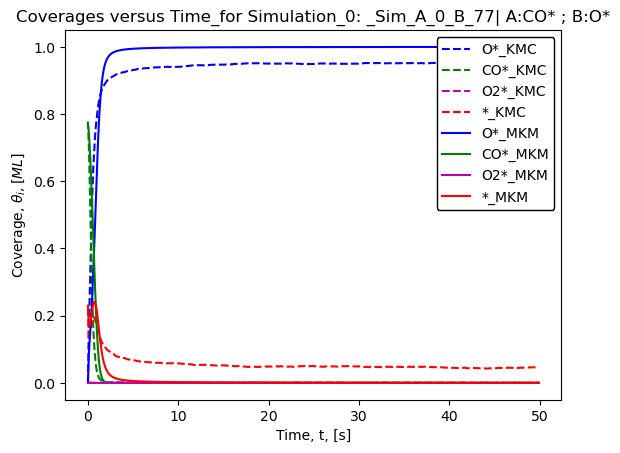

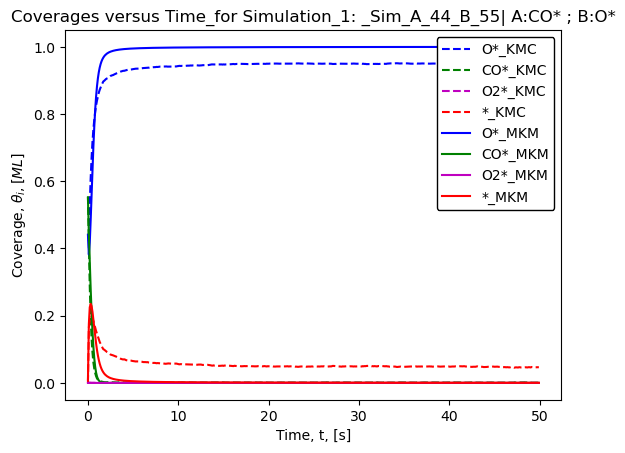

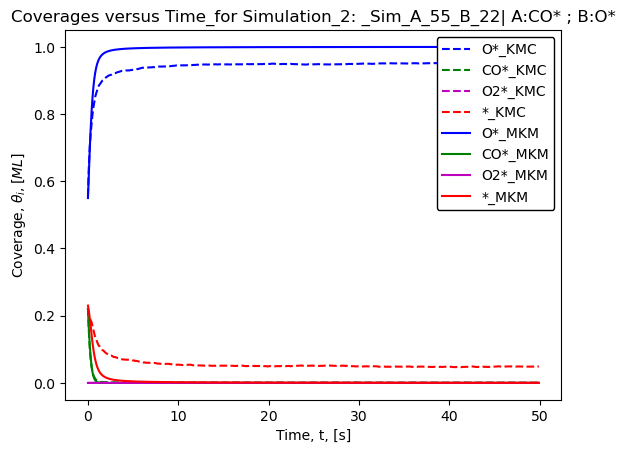

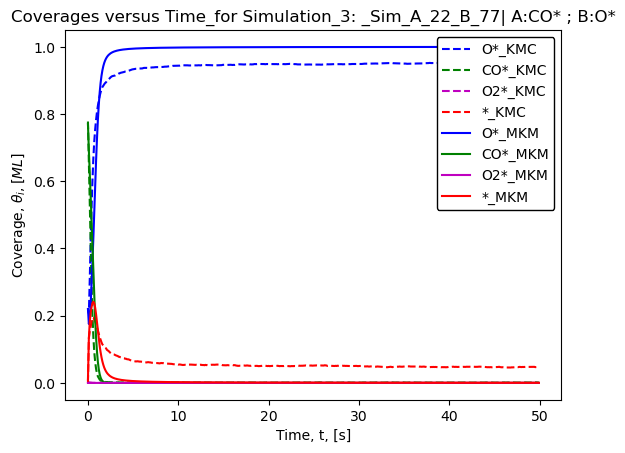

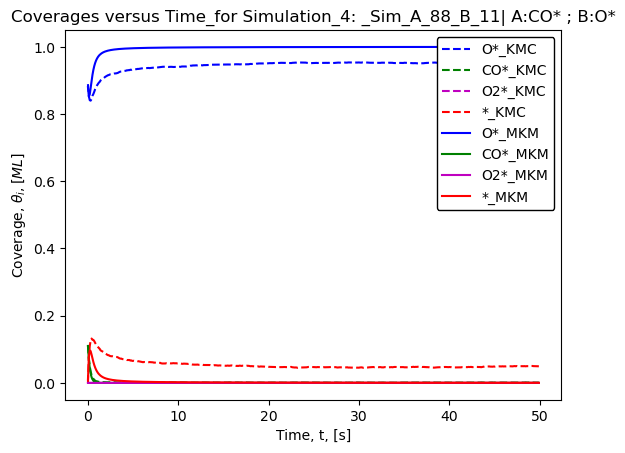

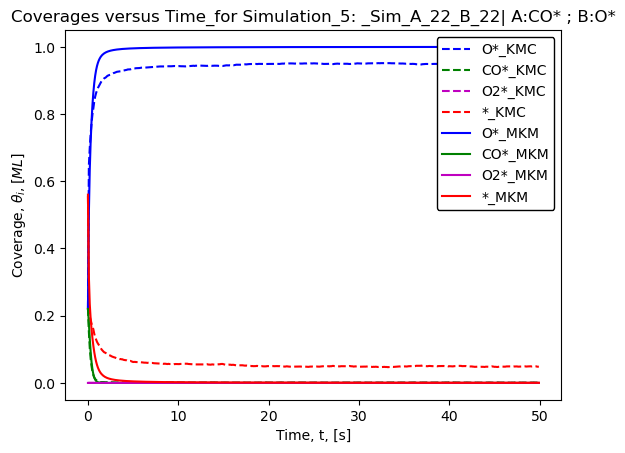

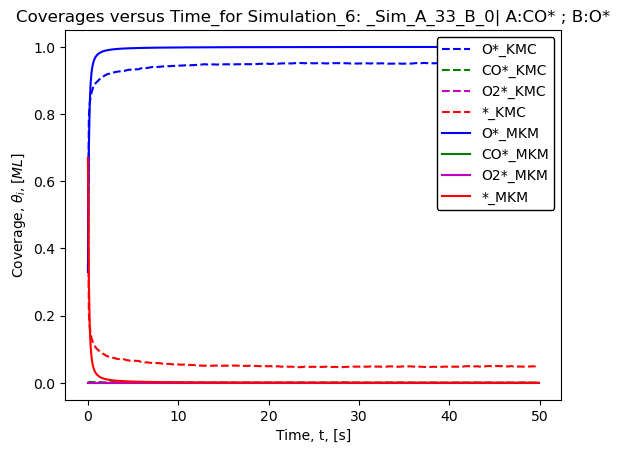

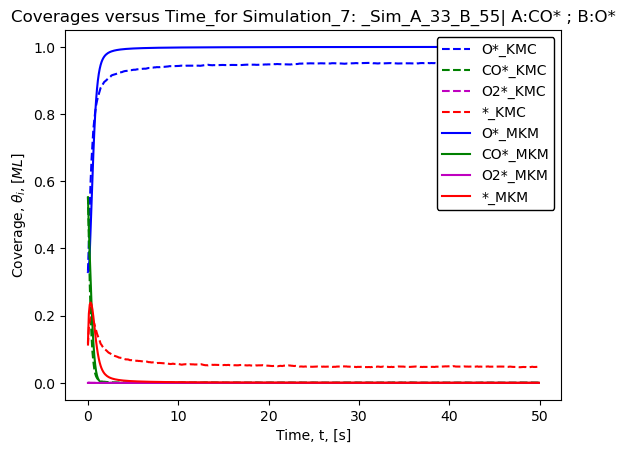

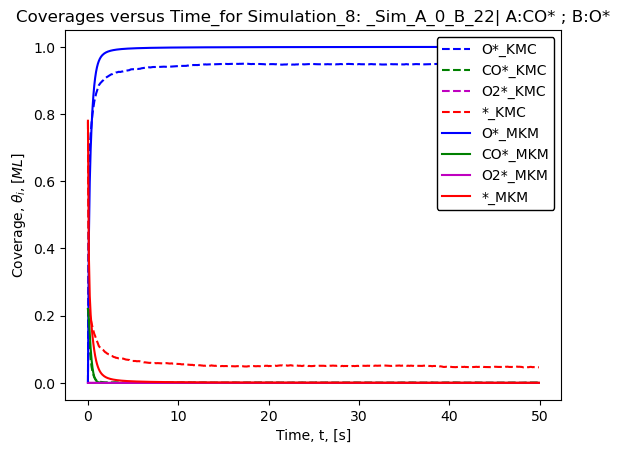

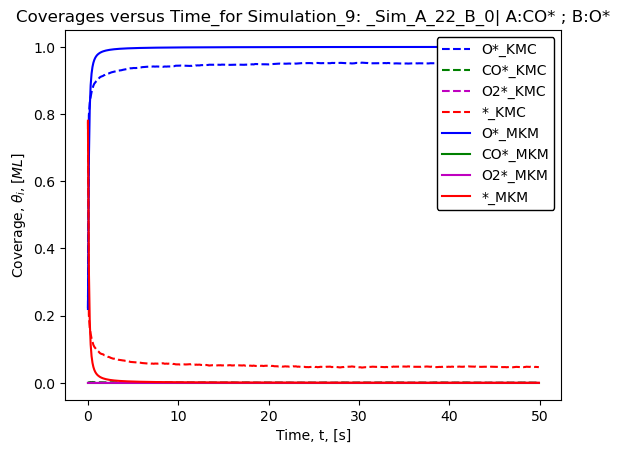

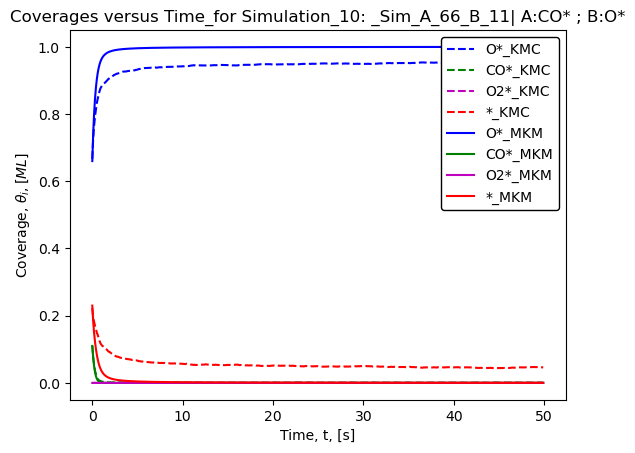

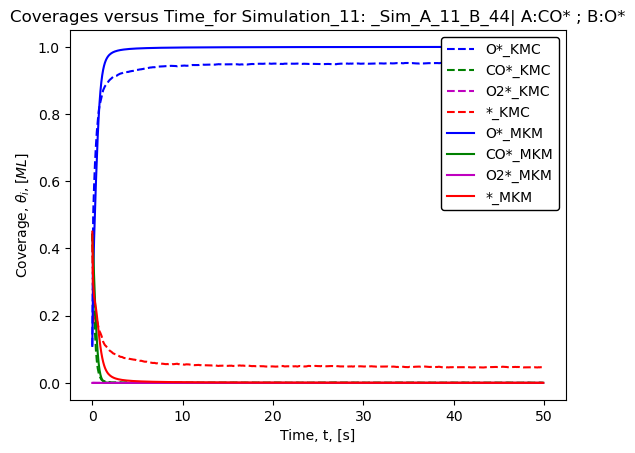

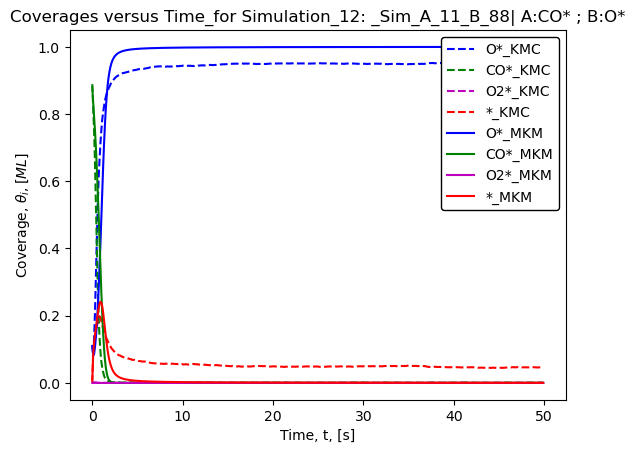

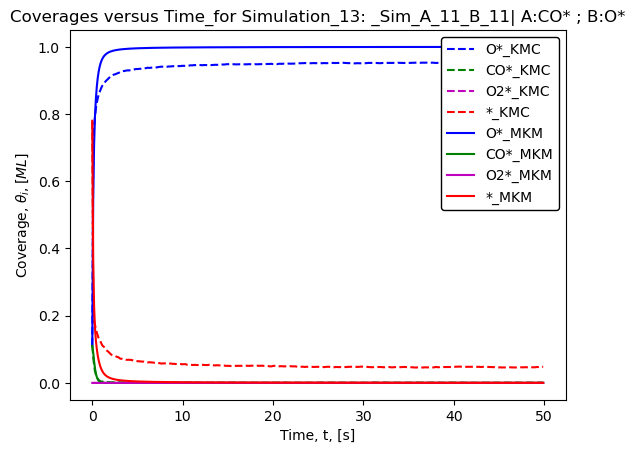

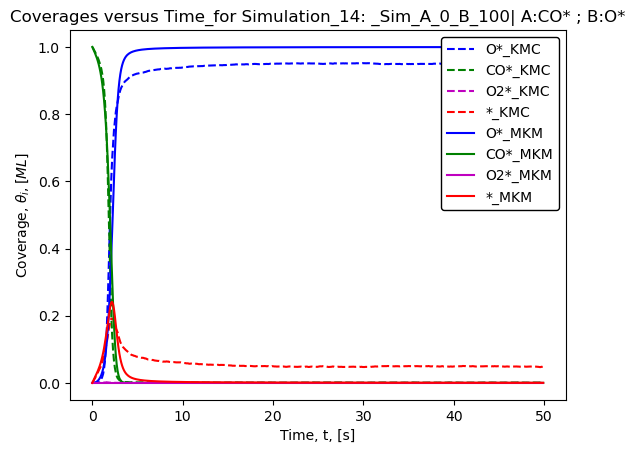

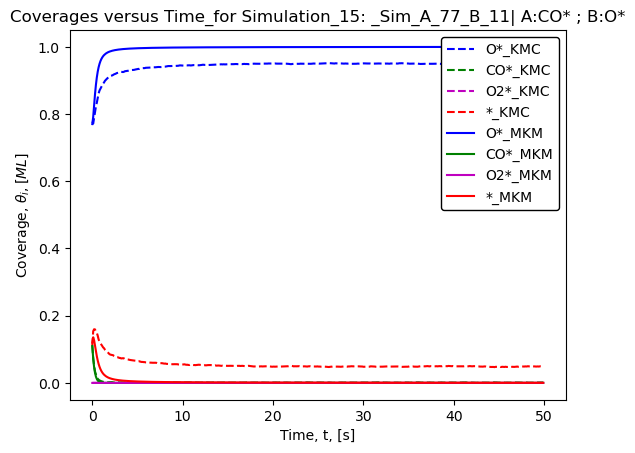

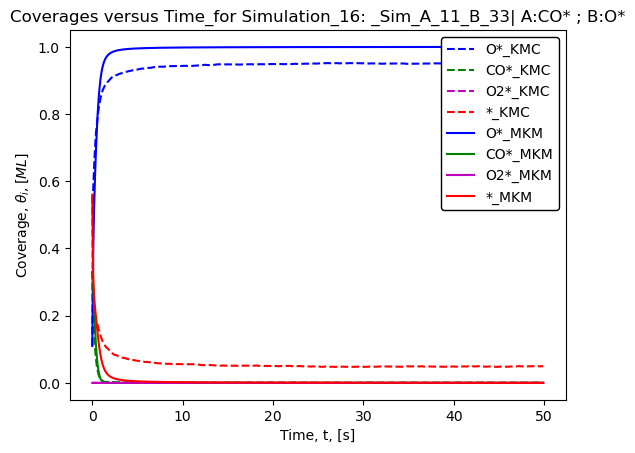

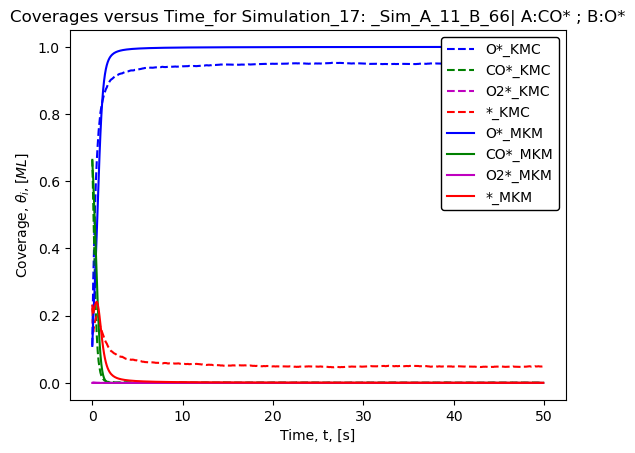

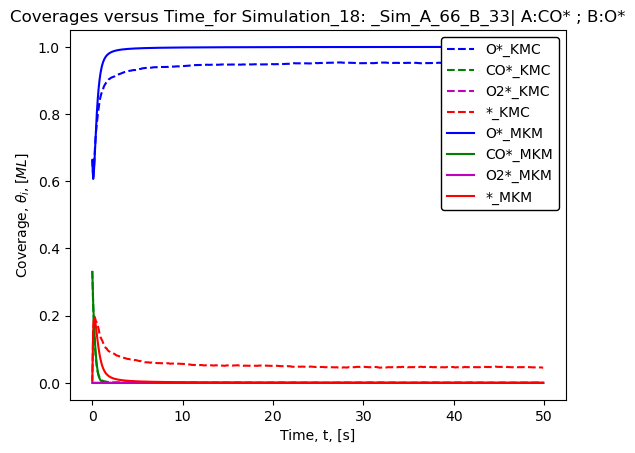

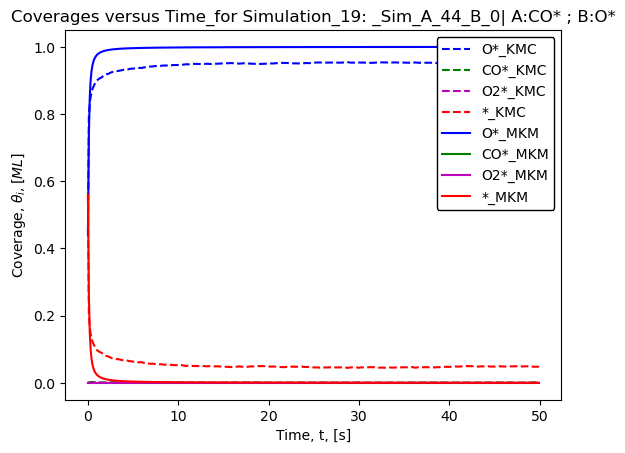

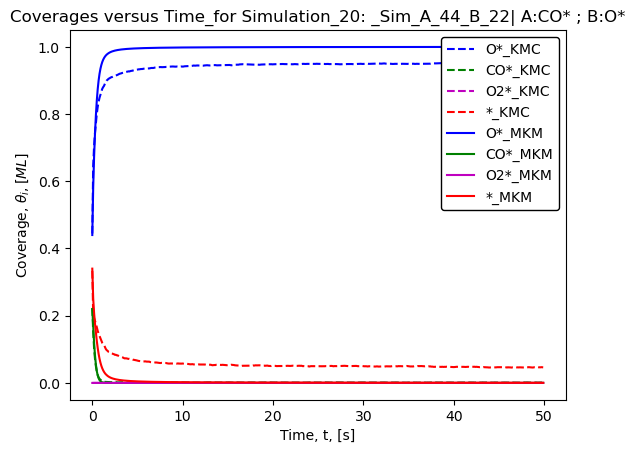

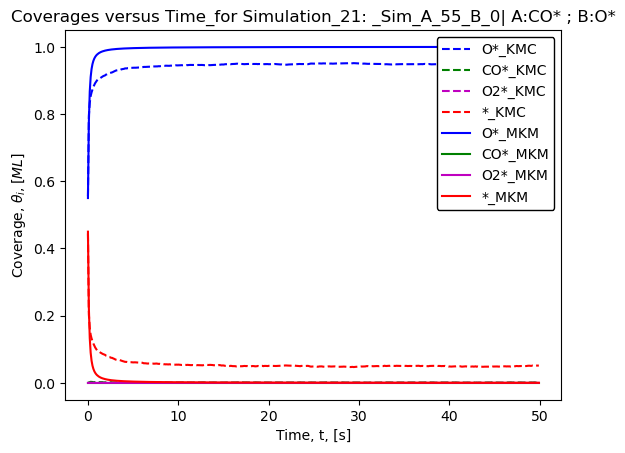

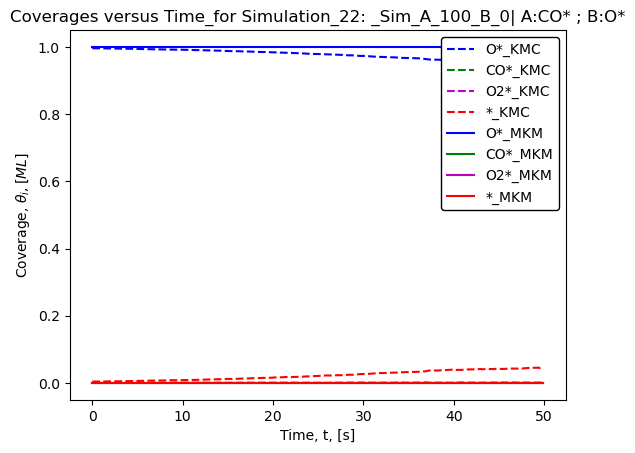

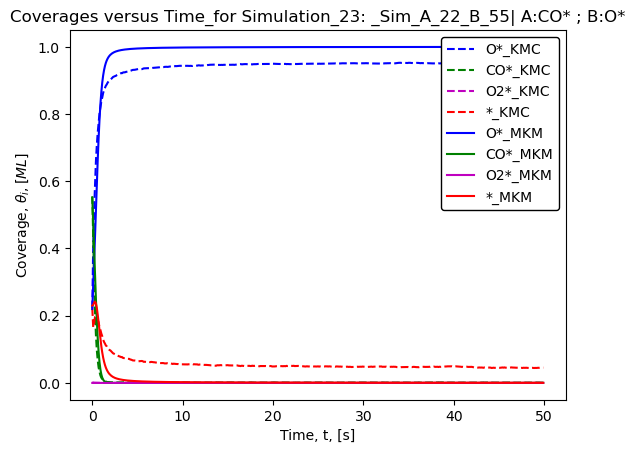

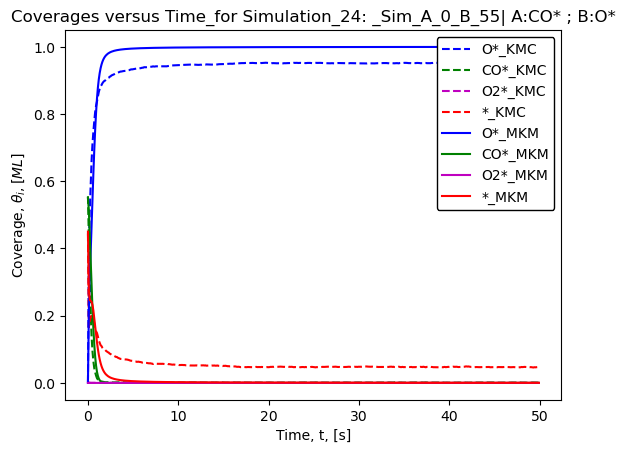

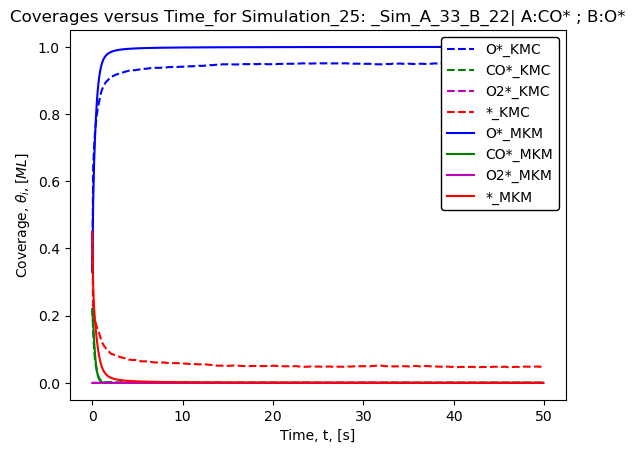

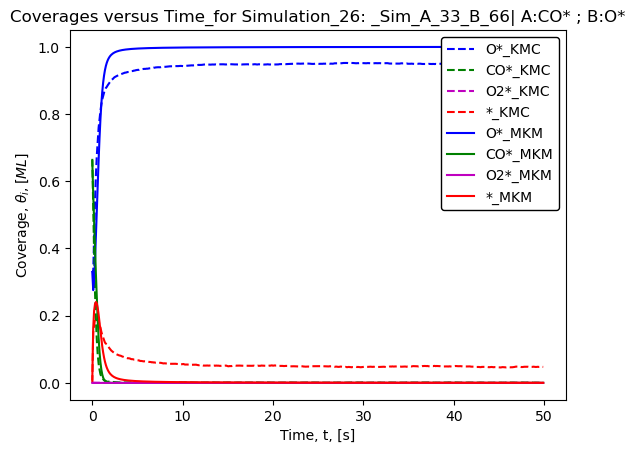

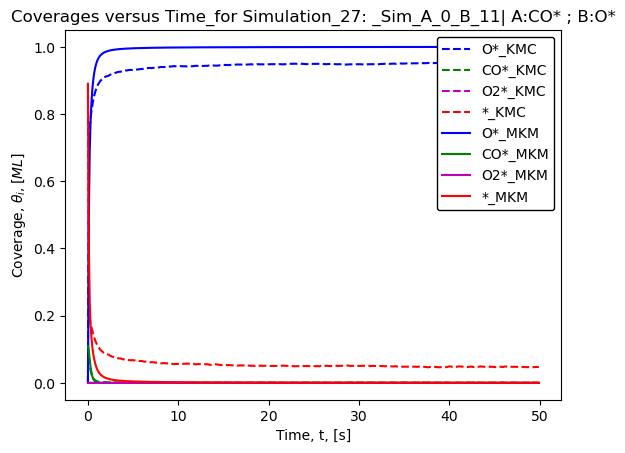

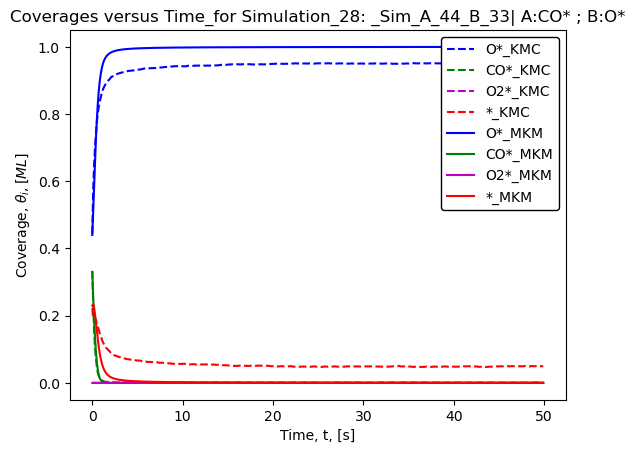

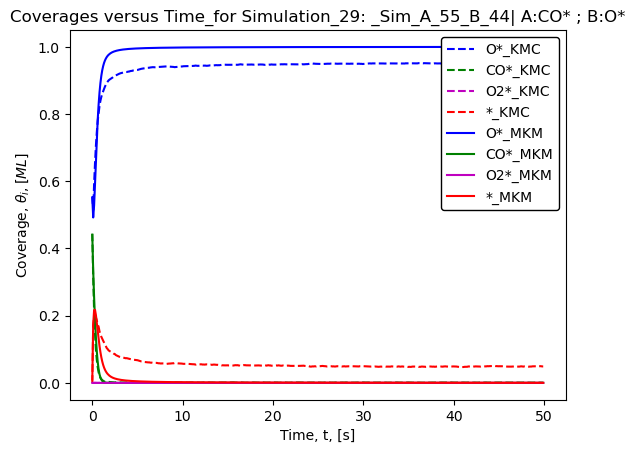

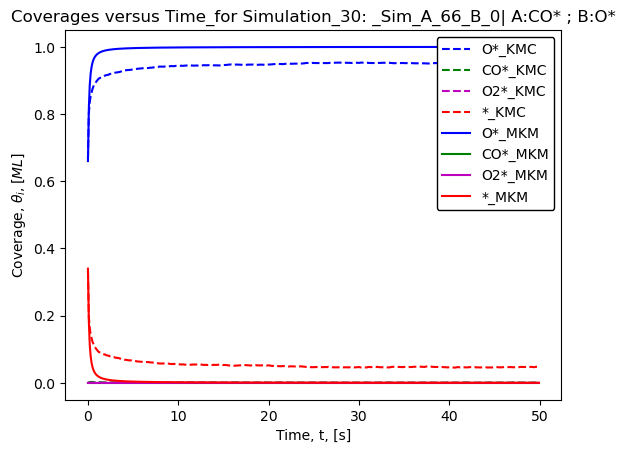

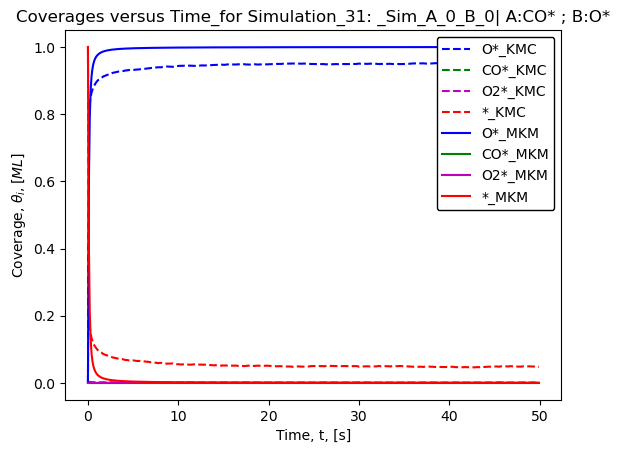

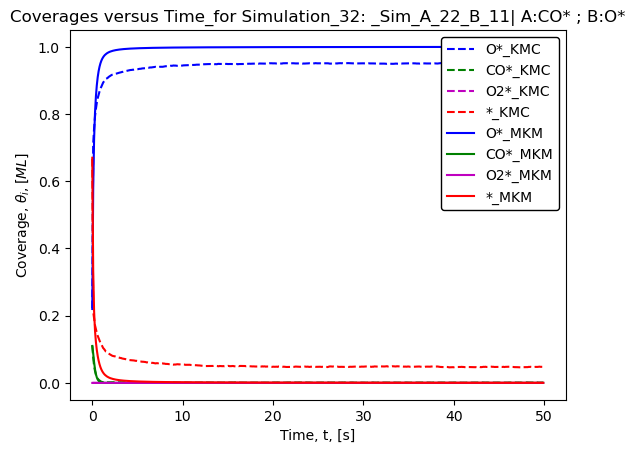

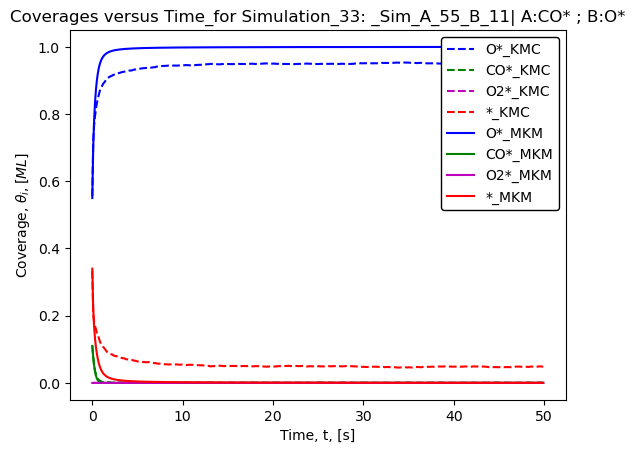

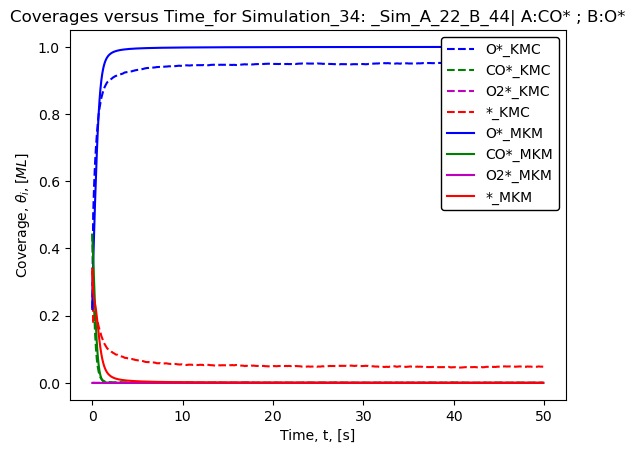

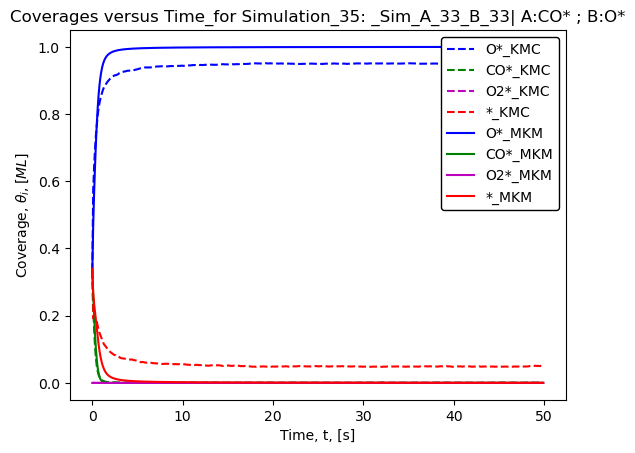

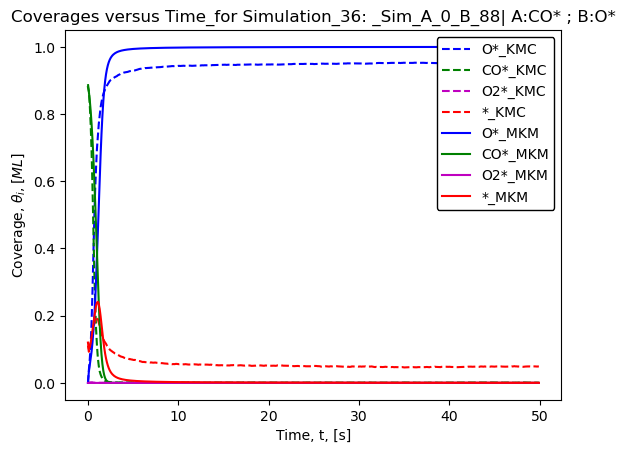

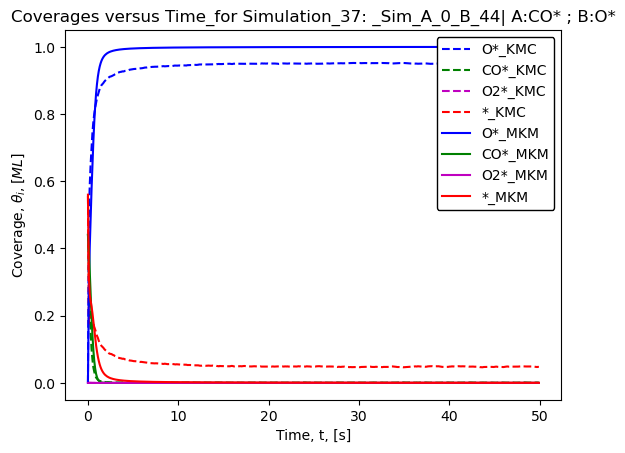

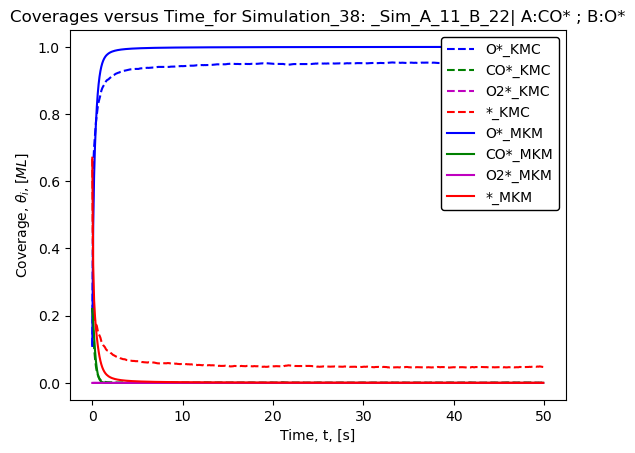

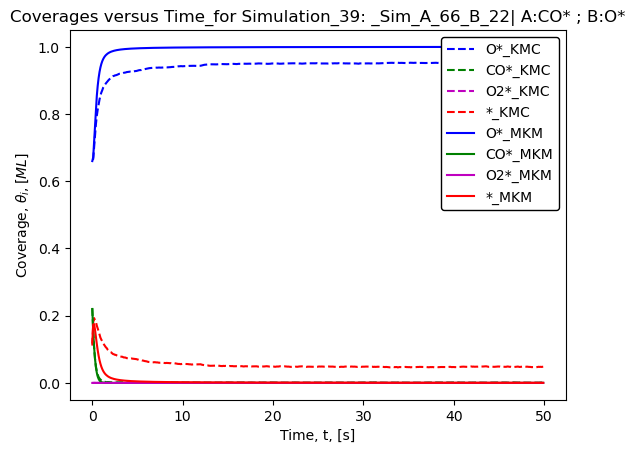

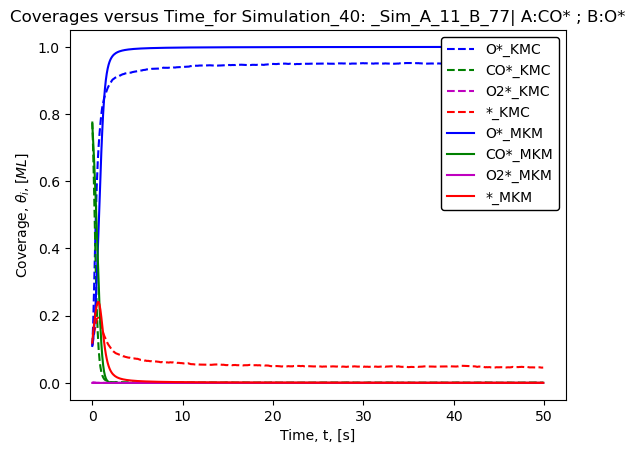

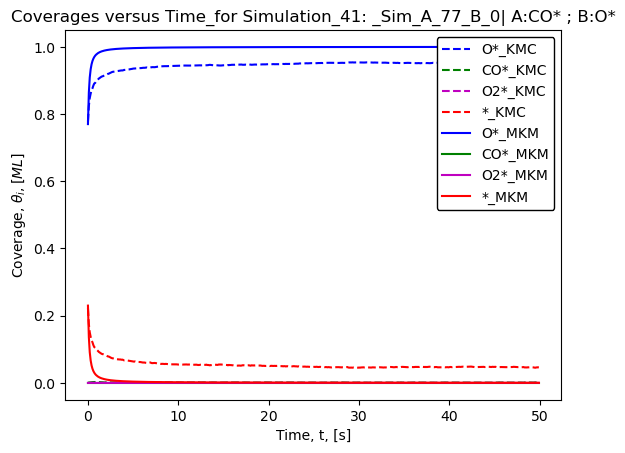

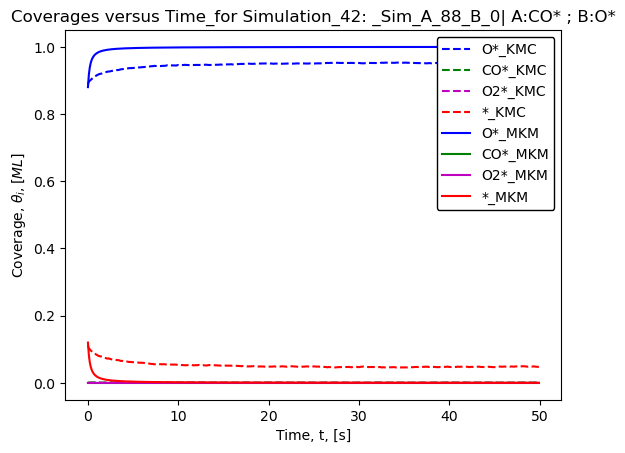

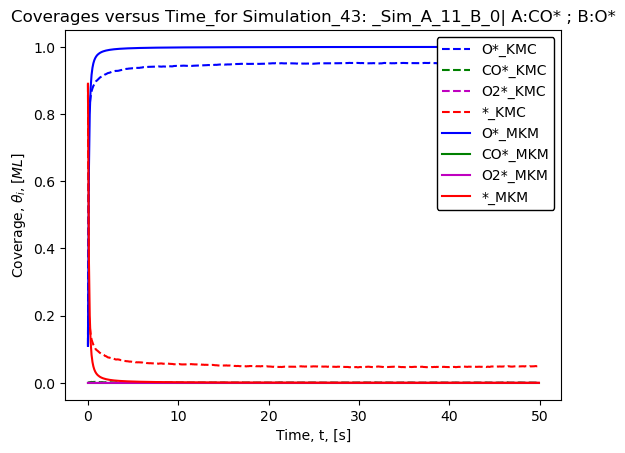

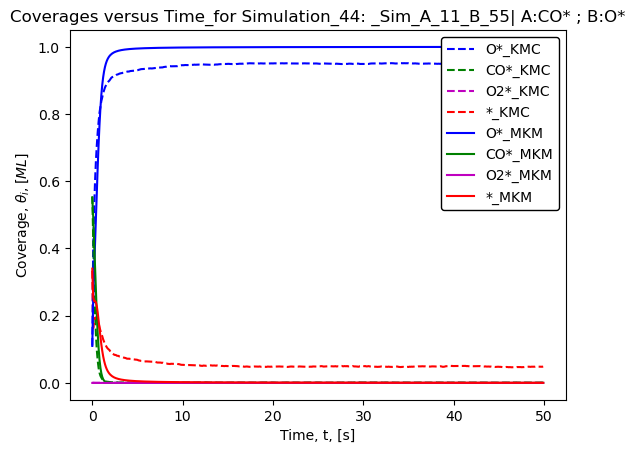

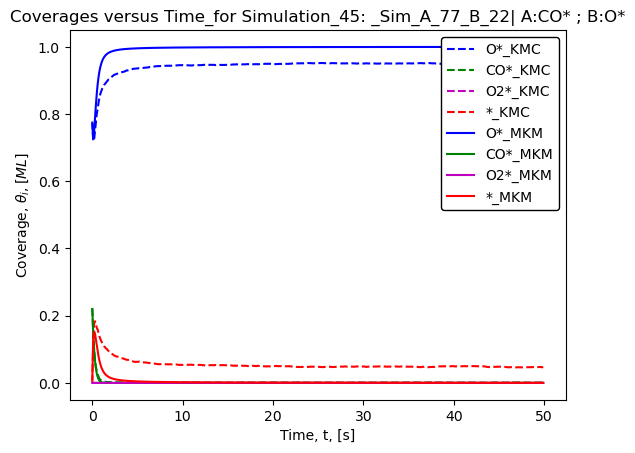

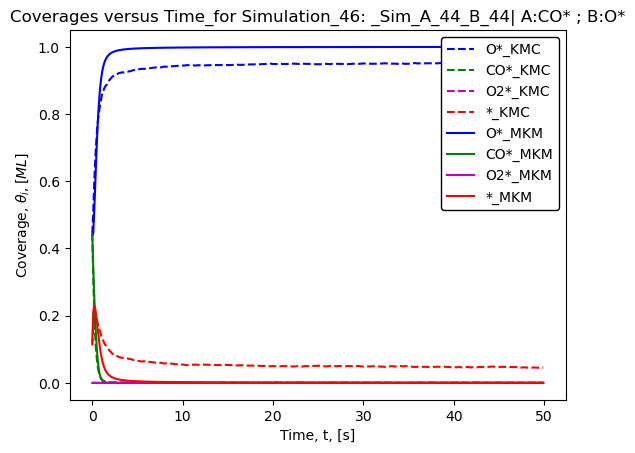

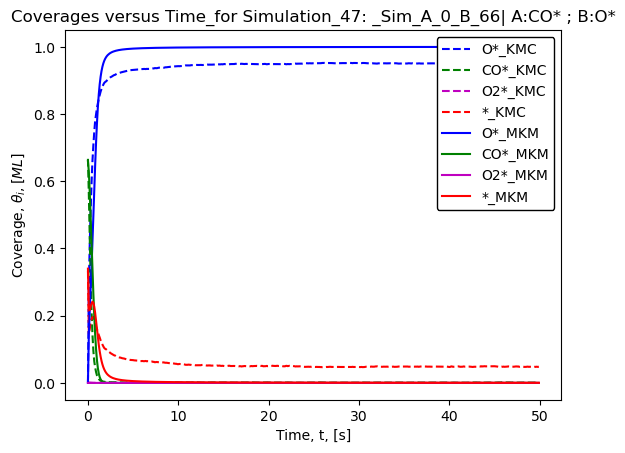

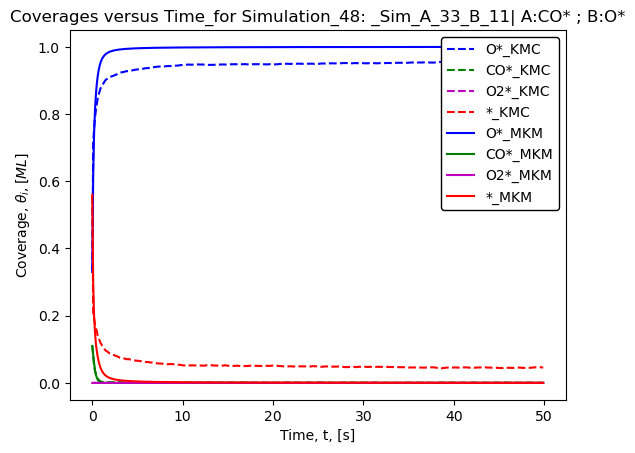

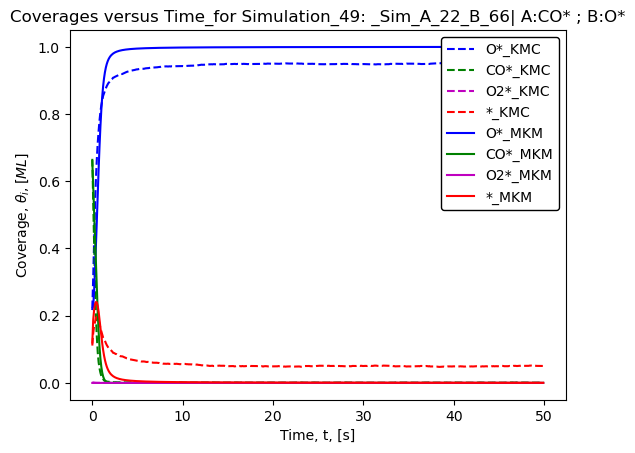

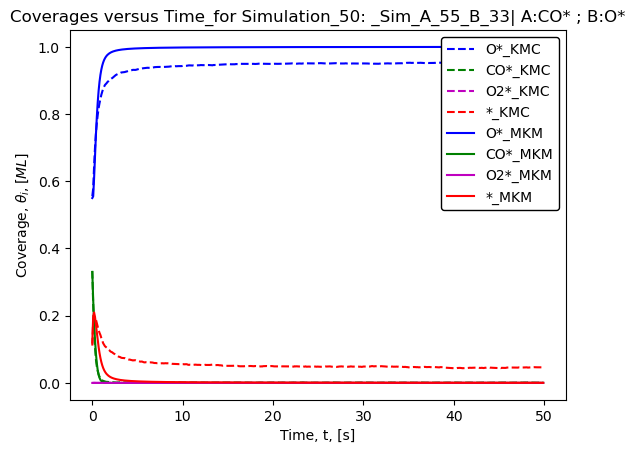

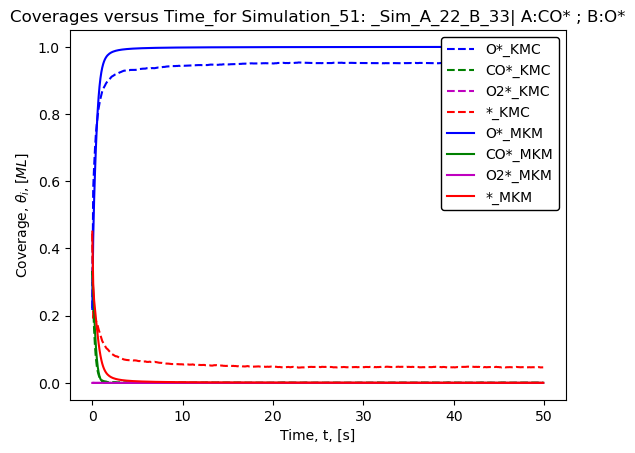

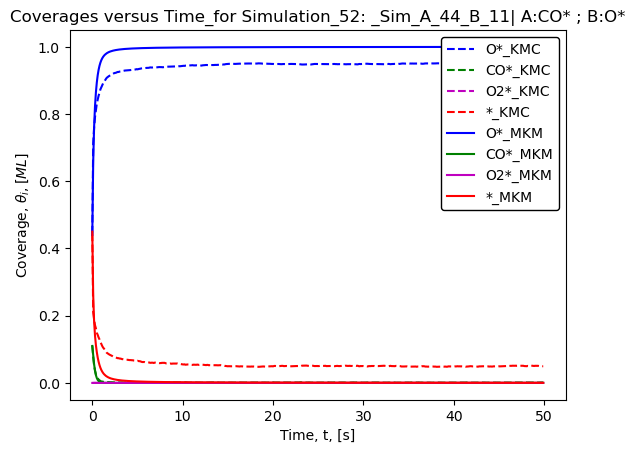

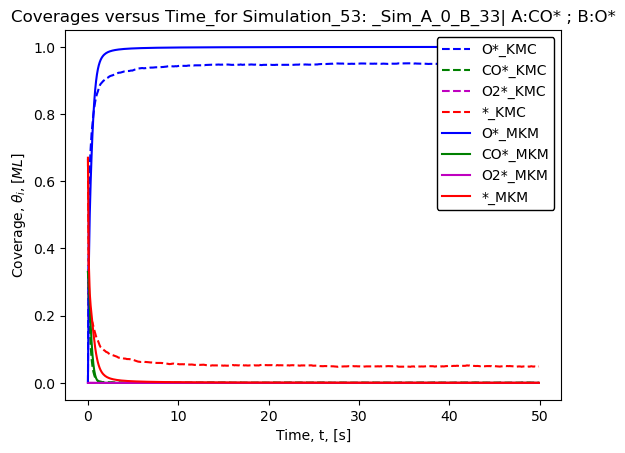

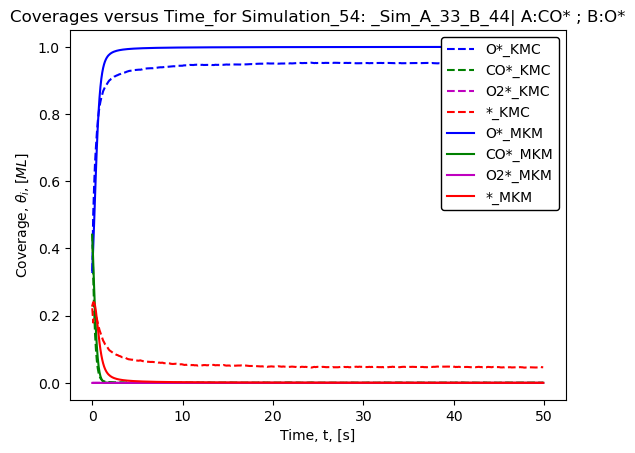

In [28]:
%%time
#Part 1: Choose the feature of which you we will compare the k-opt values

# Comp = 'iRates'
Comp = 'Covg'
colors = ['b','g','m','r','c','y','k'] 

print('Comparison of KMC vs fitted-k MKM results for' + Comp)

#Part 2: Plot comparison results for fitting analysis
for i in np.arange(len(set(out_df['Sim_ndex']))): #For each simulation:
        #Extracting KMC results: ------------------------------------------------
        df = out_df.loc[out_df['Sim_ndex'] == str(i)] #Extracting dataframe only corresponding to simulation i
        kmc_dat = df[[col for col in df if 'KMC_'+Comp in col]].to_numpy() #Extracting KMC comp data as array
        Time = df['Time'].to_numpy()

        #Plotting KMC result : ------------------------------------------------          
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        for i in np.arange(len(kmc_dat[0,:])):
            ax.plot(Time, kmc_dat[:,i],colors[i]+'--')
                        
        if Comp =='iRates':
            leg_nd = (o.iloc[0,Gspecies].tolist())
            ax.set_ylim([-0.2,0.2])
        elif Comp == 'Covg':
            leg_nd = (o.iloc[0,Sspecies].tolist())
            
        ax.set_xlabel('Time, t, [s]')
        if Comp =='iRates':
            ax.set_ylabel(r"Rates of Production, $R_i$")
            ax.set_title('Rates of production versus Time_ for Simulation_'+ df['Sim_ndex'].iloc[i] +': _'+df['Sim_names'].iloc[0]+'| A:CO* ; B:O*')
        elif Comp == 'Covg':
            ax.set_ylabel(r"Coverage, $\theta_i, [ML]$")
            ax.set_title('Coverages versus Time_for Simulation_'+ df['Sim_ndex'].iloc[i] +': _'+df['Sim_names'].iloc[0]+'| A:CO* ; B:O*')
        
        
        #Extracting MKM results: ------------------------------------------------
        mkm_dat = df[[col for col in df if 'MKM_'+Comp in col]].to_numpy() #Extracting MKM comp data as array
        Time = df['Time'].to_numpy()
            
            
        #Adding to the plot, MKM result : ------------------------------------------------     
        for i in np.arange(len(mkm_dat[0,:])):
            ax.plot(Time, mkm_dat[:,i],colors[i]+'-')
        
        #Plotting all the legends together
        ax.legend([f"{string}_KMC" for string in leg_nd]+[f"{string}_MKM" for string in leg_nd],fontsize=10, loc='upper right',facecolor='white', edgecolor ='black', framealpha=1)


# Representation in 3D

### Selecting only a few simulations to be represented in 3D

In [29]:
import random
p_test = 1 #Percent test data
print('Percent of test data selected:',p_test*100,'%')


max_sim_number = int(len(set(out_df['Sim_ndex']))) #MAx_number of simulations present #Count is starting from 0
n_test_sim = int(p_test*max_sim_number) #Number of simulations being used as test
sim_nums = list(set(out_df['Sim_ndex'])) # List of unique simulation numbers

test_sims = random.sample(sim_nums,n_test_sim) #Random sim_numbers for testing

print('\n','The list of simulations used in the test dataset:\n',test_sims)

# params = np.array([5.60983514e+07, 6.26873886e-10, 2.09163588e+04, 8.74022929e+09, 1.03443448e+10, 2.75903622e-01, 1.03031697e+08, 5.00000000e+02])
New_out_df = out_df.loc[out_df['Sim_ndex'].isin(test_sims)]
New_out_df

Percent of test data selected: 100 %

 The list of simulations used in the test dataset:
 ['43', '0', '44', '2', '4', '27', '24', '33', '41', '6', '52', '19', '38', '39', '13', '20', '31', '14', '46', '54', '47', '30', '50', '21', '25', '45', '17', '53', '40', '34', '7', '29', '48', '28', '37', '15', '23', '16', '10', '22', '8', '36', '26', '12', '18', '51', '9', '3', '32', '1', '35', '11', '42', '49', '5']


,Sim_ndex,Sim_names,Init_Covg_O*,Init_Covg_CO*,Init_Covg_O2*,Init_Covg_*,Time,KMC_Covg_O*,KMC_Covg_CO*,KMC_Covg_O2*,...,KMC_iRates_O2,KMC_iRates_CO,KMC_iRates_CO2,MKM_Covg_O*,MKM_Covg_CO*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRates_O2,MKM_iRates_CO,MKM_iRates_CO2
0,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.0,0.000000,0.777724,0.000000,...,-1.280924,0.022244,0.501573,0.000000,7.700000e-01,0.000000e+00,0.230000,-1.364789,4.675783e-02,0.000000e+00
1,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.1,0.167318,0.704590,0.001139,...,-1.122504,0.025499,0.913357,0.085270,7.457032e-01,6.143147e-07,0.169026,-0.436772,4.528242e-02,3.340825e-01
2,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.2,0.263292,0.589952,0.001519,...,-1.126031,0.016819,1.204970,0.129954,7.000486e-01,6.163021e-07,0.169997,-0.440702,4.251007e-02,4.779770e-01
3,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.3,0.377604,0.460232,0.000705,...,-1.178657,0.004612,1.266547,0.171168,6.429794e-01,6.474018e-07,0.185852,-0.506117,3.904458e-02,5.782432e-01
4,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.4,0.483724,0.335720,0.000380,...,-1.056315,0.000814,1.130914,0.218225,5.771402e-01,6.812329e-07,0.204634,-0.586385,3.504652e-02,6.617238e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.5,0.952528,0.000868,0.000054,...,-0.000814,-0.003526,0.004883,0.999616,2.745178e-12,2.468938e-09,0.000384,-0.000004,-1.436610e-11,1.441762e-11
27496,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.6,0.952040,0.000543,0.000000,...,-0.001628,-0.002984,0.003798,0.999617,2.739297e-12,2.463829e-09,0.000383,-0.000004,-1.433634e-11,1.438675e-11
27497,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.7,0.952311,0.000705,0.000109,...,-0.002170,-0.004883,0.002984,0.999617,2.733576e-12,2.458742e-09,0.000383,-0.000004,-1.430669e-11,1.435671e-11
27498,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.8,0.952203,0.000922,0.000054,...,-0.001085,-0.005697,0.003255,0.999618,2.728043e-12,2.453675e-09,0.000382,-0.000004,-1.427715e-11,1.432766e-11


<IPython.core.display.Javascript object>


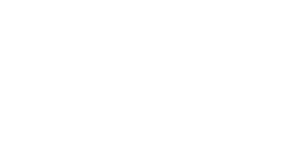

<IPython.core.display.Javascript object>


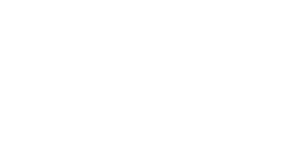

/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_13774/3527544795.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.array(list(set(New_out_df['Sim_names']))),fontdict={'fontsize': 6,'fontweight': 10,'verticalalignment': 'baseline'})


In [30]:
%matplotlib notebook
##Constructing a waterfall plot
from matplotlib.collections import PolyCollection
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
import numpy as np
import matplotlib

# Comp = 'iRates'
Comp = 'Covg'

axes=plt.axes(projection="3d")
plt.figure(Comp+'Exp_only')
def colors(arg):
    return mcolors.to_rgba(arg, alpha=6)

x1 = New_out_df.loc[New_out_df['Sim_ndex'] == New_out_df.iloc[0][0]]['Time'].to_numpy()  #Sim_ndex = fist sim on the list and then find array of corresponding time
verts1 = []
verts2= []
Sim_len = len(set(New_out_df['Sim_ndex']))
sims = np.array(list(set(New_out_df['Sim_ndex'])))
z1 = np.arange(Sim_len)
for z in z1:
    df = New_out_df.loc[New_out_df['Sim_ndex'] == str(sims[z])] #Extracting only the dataframe corrsponding to simulation z
    y1 = df[[col for col in df if 'KMC_'+Comp+'_O*' in col]].to_numpy()
    y2 = df[[col for col in df if 'KMC_'+Comp+'_CO*' in col]].to_numpy()
#     y1[0], y1[-1] = 0, 0
    verts1.append(list(zip(x1, y1)))
    verts2.append(list(zip(x1, y2)))
    
facecolors = [matplotlib.cm.jet(x) for x in np.random.rand(Sim_len)]

poly1 = LineCollection(verts1,color = facecolors,linewidths=(1,),zorder=2,linestyle='-')
poly2 = LineCollection(verts2,color = facecolors,linewidths=(1,),zorder=2,linestyle='--')

# Removes shaded region
poly1.set_facecolor(None)
poly2.set_facecolor(None)


poly1.set_alpha(0.6)
poly2.set_alpha(0.6)
axes.add_collection3d(poly1, zs=z1, zdir='y')
axes.add_collection3d(poly2, zs=z1, zdir='y')

axes.set_xlabel('X : Time')
axes.set_xlim3d(0, x1[-1])
axes.set_ylabel('Y : Simulation')
axes.set_ylim3d(0, Sim_len,auto=False)
# axes.yticks(sims.astype(float))
# axes.set_yticks(sims.astype(float))
axes.set_yticklabels(np.array(list(set(New_out_df['Sim_names']))),fontdict={'fontsize': 6,'fontweight': 10,'verticalalignment': 'baseline'})
axes.set_zlabel(Comp)
# axes.set_zlim3d(0, 1)
# axes.set_zlim3d(-0.2, 0.2)
axes.set_title("KMC_Results")

line_1 = Line2D([0], [0], color='black', linewidth=0.6, linestyle='-') 
line_2 = Line2D([0], [0], color='black', linewidth=0.6, linestyle='--')

label_1 = 'KMC_'+'Covg_O*'
label_2 = 'KMC_'+'Covg_CO*'

lines = [line_1,line_2]
labels = [label_1,label_2]
axes.legend(lines, labels, title = "A: CO* | B: O*", loc='best',fontsize=6,title_fontsize=6)


plt.show()

## iRates

<IPython.core.display.Javascript object>


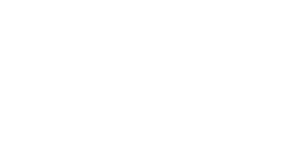

/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_13774/2687071380.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.array(list(set(New_out_df['Sim_names']))),fontdict={'fontsize': 6,'fontweight': 10})


<IPython.core.display.Javascript object>


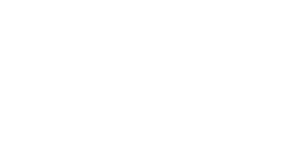

/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_13774/2687071380.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.array(list(set(New_out_df['Sim_names']))),fontdict={'fontsize': 6,'fontweight': 10})


<IPython.core.display.Javascript object>


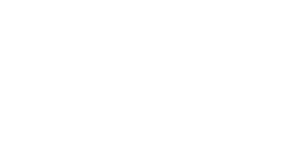

/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_13774/2687071380.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.array(list(set(New_out_df['Sim_names']))),fontdict={'fontsize': 6,'fontweight': 10})


In [31]:
%matplotlib notebook
#iRates
##Constructing a waterfall plot
from matplotlib.collections import PolyCollection
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
import numpy as np
import matplotlib

Comp = 'iRates'
g_sp = (o.iloc[0,Gspecies].tolist()) #Gas Species list

for i in np.arange(len(g_sp)):
    plt.figure(Comp+str(i))
    axes=plt.axes(projection="3d")

    def colors(arg):
        return mcolors.to_rgba(arg, alpha=6)

    x1 = New_out_df.loc[New_out_df['Sim_ndex'] == New_out_df.iloc[0][0]]['Time'].to_numpy()  #Sim_ndex = fist sim on the list and then find array of corresponding time
    verts1 = []
    verts2= []
    Sim_len = len(set(New_out_df['Sim_ndex']))
    sims = np.array(list(set(New_out_df['Sim_ndex'])))
    z1 = np.arange(Sim_len)
    for z in z1:
        df = New_out_df.loc[New_out_df['Sim_ndex'] == str(sims[z])] #Extracting only the dataframe corrsponding to simulation z
        KMC_vals = df[[col for col in df if 'KMC_'+Comp+'_'+g_sp[i] in col]].to_numpy()
        MKM_vals = df[[col for col in df if 'MKM_'+Comp+'_'+g_sp[i] in col]].to_numpy()

        if g_sp[i]=='CO':
            y1 = KMC_vals[:,0]
            y2 = MKM_vals[:,0]
        else:
            y1 = KMC_vals
            y2 = MKM_vals

        verts1.append(list(zip(x1, y1)))
        verts2.append(list(zip(x1, y2)))

    facecolors = [matplotlib.cm.jet(x) for x in np.random.rand(Sim_len)]

    poly1 = LineCollection(verts1,color = facecolors,linewidths=(1,),zorder=2,linestyle='-')
    poly2 = LineCollection(verts2,color = facecolors,linewidths=(1,),zorder=2,linestyle='--')

    # Removes shaded region
    poly1.set_facecolor(None)
    poly2.set_facecolor(None)


    poly1.set_alpha(0.6)
    poly2.set_alpha(0.6)
    axes.add_collection3d(poly1, zs=z1, zdir='y')
    axes.add_collection3d(poly2, zs=z1, zdir='y')

    axes.set_xlabel('X : Time')
    axes.set_xlim3d(0, x1[-1])
    axes.set_ylabel('Y : Simulation')
    axes.set_ylim3d(0, Sim_len,auto=False)
    axes.set_yticklabels(np.array(list(set(New_out_df['Sim_names']))),fontdict={'fontsize': 6,'fontweight': 10})
    axes.set_zlabel(Comp)
    axes.set_zlim3d(-0.2, 0.2)
    axes.set_title(Comp+"_Results")

    line_1 = Line2D([0], [0], color='black', linewidth=0.6, linestyle='-') 
    line_2 = Line2D([0], [0], color='black', linewidth=0.6, linestyle='--')

    label_1 = 'KMC_'+Comp+'_'+g_sp[i]
    label_2 = 'MKM_'+Comp+'_'+g_sp[i]

    lines = [line_1,line_2]
    labels = [label_1,label_2]
    axes.legend(lines, labels, title = "A: CO* | B: O*", loc='best',fontsize=6,title_fontsize=6)

    plt.show()


## Coverages

<IPython.core.display.Javascript object>


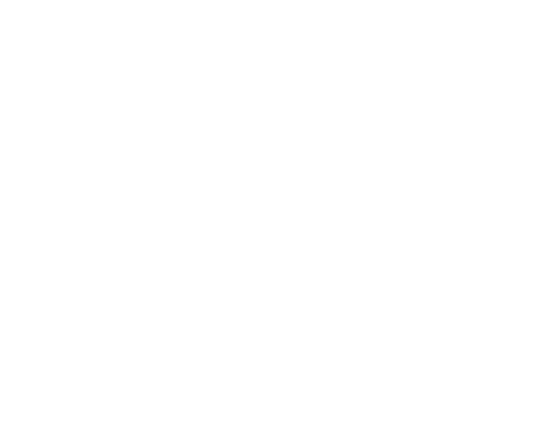

/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_13774/2530541192.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.array(list(set(New_out_df['Sim_names']))),fontdict={'fontsize': 6,'fontweight': 10})


<IPython.core.display.Javascript object>


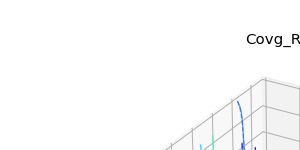

/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_13774/2530541192.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.array(list(set(New_out_df['Sim_names']))),fontdict={'fontsize': 6,'fontweight': 10})


<IPython.core.display.Javascript object>


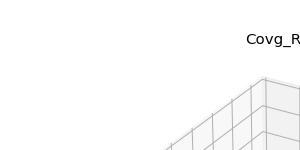

/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_13774/2530541192.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.array(list(set(New_out_df['Sim_names']))),fontdict={'fontsize': 6,'fontweight': 10})


In [32]:
%matplotlib notebook
#Coverages
##Constructing a waterfall plot
from matplotlib.collections import PolyCollection
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
import numpy as np
import matplotlib

Comp = 'Covg'
s_sp = (o.iloc[0,Sspecies].tolist()) #Gas Species list

for i in np.arange(len(g_sp)):
    plt.figure(Comp+str(i))
    axes=plt.axes(projection="3d")

    def colors(arg):
        return mcolors.to_rgba(arg, alpha=6)

    x1 = New_out_df.loc[New_out_df['Sim_ndex'] == New_out_df.iloc[0][0]]['Time'].to_numpy()  #Sim_ndex = fist sim on the list and then find array of corresponding time
    verts1 = []
    verts2= []
    Sim_len = len(set(New_out_df['Sim_ndex']))
    sims = np.array(list(set(New_out_df['Sim_ndex'])))
    z1 = np.arange(Sim_len)
    for z in z1:
        df = New_out_df.loc[New_out_df['Sim_ndex'] == str(sims[z])] #Extracting only the dataframe corrsponding to simulation z
        KMC_vals = df[[col for col in df if 'KMC_'+Comp+'_'+s_sp[i] in col]].to_numpy()
        MKM_vals = df[[col for col in df if 'MKM_'+Comp+'_'+s_sp[i] in col]].to_numpy()

        y1 = KMC_vals
        y2 = MKM_vals

        verts1.append(list(zip(x1, y1)))
        verts2.append(list(zip(x1, y2)))

    facecolors = [matplotlib.cm.jet(x) for x in np.random.rand(Sim_len)]

    poly1 = LineCollection(verts1,color = facecolors,linewidths=(1,),zorder=2,linestyle='-')
    poly2 = LineCollection(verts2,color = facecolors,linewidths=(1,),zorder=2,linestyle='--')

    # Removes shaded region
    poly1.set_facecolor(None)
    poly2.set_facecolor(None)


    poly1.set_alpha(0.6)
    poly2.set_alpha(0.6)
    axes.add_collection3d(poly1, zs=z1, zdir='y')
    axes.add_collection3d(poly2, zs=z1, zdir='y')

    axes.set_xlabel('X : Time')
    axes.set_xlim3d(0, x1[-1])
    axes.set_ylabel('Y : Simulation')
    axes.set_ylim3d(0, Sim_len,auto=False)
    axes.set_yticklabels(np.array(list(set(New_out_df['Sim_names']))),fontdict={'fontsize': 6,'fontweight': 10})
    axes.set_zlabel(Comp)
    axes.set_zlim3d(0, 1)
    axes.set_title(Comp+"_Results")

    line_1 = Line2D([0], [0], color='black', linewidth=0.6, linestyle='-') 
    line_2 = Line2D([0], [0], color='black', linewidth=0.6, linestyle='--')

    label_1 = 'KMC_'+Comp+'_'+s_sp[i]
    label_2 = 'MKM_'+Comp+'_'+s_sp[i]

    lines = [line_1,line_2]
    labels = [label_1,label_2]
    axes.legend(lines, labels, title = "A: CO* | B: O*", loc='best',fontsize=6,title_fontsize=6)

    plt.show()


## Dropping KMC columns to clean up ML dataset

In [33]:
out_df = out_df[out_df.columns.drop(list(out_df.filter(regex='KMC_')))]
out_df

,Sim_ndex,Sim_names,Init_Covg_O*,Init_Covg_CO*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_O*,MKM_Covg_CO*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRates_O2,MKM_iRates_CO,MKM_iRates_CO2
0,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.0,0.000000,7.700000e-01,0.000000e+00,0.230000,-1.364789,4.675783e-02,0.000000e+00
1,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.1,0.085270,7.457032e-01,6.143147e-07,0.169026,-0.436772,4.528242e-02,3.340825e-01
2,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.2,0.129954,7.000486e-01,6.163021e-07,0.169997,-0.440702,4.251007e-02,4.779770e-01
3,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.3,0.171168,6.429794e-01,6.474018e-07,0.185852,-0.506117,3.904458e-02,5.782432e-01
4,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.4,0.218225,5.771402e-01,6.812329e-07,0.204634,-0.586385,3.504652e-02,6.617238e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.5,0.999616,2.745178e-12,2.468938e-09,0.000384,-0.000004,-1.436610e-11,1.441762e-11
27496,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.6,0.999617,2.739297e-12,2.463829e-09,0.000383,-0.000004,-1.433634e-11,1.438675e-11
27497,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.7,0.999617,2.733576e-12,2.458742e-09,0.000383,-0.000004,-1.430669e-11,1.435671e-11
27498,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.8,0.999618,2.728043e-12,2.453675e-09,0.000382,-0.000004,-1.427715e-11,1.432766e-11


***
<a id="2.3"></a> 
## 2.C  Creating Features:
<a href="#top">Back to top</a>

<a id="2.3.2"></a> 
## 2.C.1  Percent difference
<a href="#top">Back to top</a>

$$ p_{diff} = \frac{|r_{MKM}-r_{KMC}|}{\frac{(r_{MKM}+r_{KMC})}{2}} $$

In [34]:
rx,ry,rz = np.shape(data_KMC_dict['iRates'])
P_diff = np.zeros((rx,ry,rz)) 

In [35]:
import math
MKM_values = data_MKM_dict['iRates']
KMC_values = data_KMC_dict['iRates']

for i in np.arange(rx):
    for j in np.arange(ry):
        for k in np.arange(rz):
            mkmr = KMC_values[i,j,k]
            kmcr = MKM_values[i,j,k]      
            #Preventing nan
            if float(mkmr) == 0:
                mkmr = 1e-20
            if float(kmcr) == 0:
                kmcr = 1e-20
            val = abs(mkmr-kmcr)/((mkmr+kmcr)/2) 
            P_diff[i,j,k] = val
            if math.isinf(val) or math.isnan(val):
                raise Exception('ERROR: inf or nan is present')

<a id="2.3.1"></a> 
## 2.C.2  Log ratio correction factor
<a href="#top">Back to top</a>

$$ corr_{fac} = ln\frac{r_{KMC}}{r_{MKM}}$$

In [36]:
rx,ry,rz = np.shape(data_KMC_dict['iRates'])
Corr_fac = np.zeros((rx,ry,rz)) 

In [37]:
import math
MKM_values = data_MKM_dict['iRates']
KMC_values = data_KMC_dict['iRates']

for i in np.arange(rx):
    for j in np.arange(ry):
        for k in np.arange(rz):
            num = KMC_values[i,j,k]
            den = MKM_values[i,j,k]
            #Preventing log(0)
            if float(num) == 0:
                num = 1e-20
            if float(den) == 0:
                den = 1e-20
                
            frac = num/den
            if float(frac) < 0: #(i.e the rates are either being calculated as consumed versus produced)
                frac = abs(frac)
                
            val = np.log(frac)
            Corr_fac[i,j,k] = val
            if math.isinf(val) or math.isnan(val):
                raise Exception('ERROR: inf or nan is present')

# Adding Descriptors/Correction features

In [38]:
#Percent Diff
gs_names = (o.iloc[0,Gspecies].tolist())
for i in np.arange(n_gas_species):
    spec = gs_names[i]
    out_df['P_diff_'+spec] = pd.DataFrame(Tensor_To_Array(P_diff))[1+i]

#Log Correc
gs_names = (o.iloc[0,Gspecies].tolist())
for i in np.arange(n_gas_species):
    spec = gs_names[i]
    out_df['Corr_fac_'+spec] = pd.DataFrame(Tensor_To_Array(Corr_fac))[1+i]

/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_13774/3495857364.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_df['P_diff_'+spec] = pd.DataFrame(Tensor_To_Array(P_diff))[1+i]
/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_13774/3495857364.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_df['P_diff_'+spec] = pd.DataFrame(Tensor_To_Array(P_diff))[1+i]
/var/folders/_p/qwgws2w95qxf051hv3d15ky5_tzjzl/T/ipykernel_13774/3495857364.py:5: SettingWithCopyWarning: 
A value is tr

In [39]:
out_df

,Sim_ndex,Sim_names,Init_Covg_O*,Init_Covg_CO*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_O*,MKM_Covg_CO*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRates_O2,MKM_iRates_CO,MKM_iRates_CO2,P_diff_O2,P_diff_CO,P_diff_CO2,Corr_fac_O2,Corr_fac_CO,Corr_fac_CO2
0,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.0,0.000000,7.700000e-01,0.000000e+00,0.230000,-1.364789,4.675783e-02,0.000000e+00,-0.063397,0.710530,2.000000,-0.063418,-0.742913,45.361696
1,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.1,0.085270,7.457032e-01,6.143147e-07,0.169026,-0.436772,4.528242e-02,3.340825e-01,-0.879553,0.558996,0.928742,0.943907,-0.574275,1.005739
2,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.2,0.129954,7.000486e-01,6.163021e-07,0.169997,-0.440702,4.251007e-02,4.779770e-01,-0.874850,0.866074,0.863952,0.938084,-0.927257,0.924647
3,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.3,0.171168,6.429794e-01,6.474018e-07,0.185852,-0.506117,3.904458e-02,5.782432e-01,-0.798374,1.577466,0.746214,0.845363,-2.136141,0.784055
4,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.4,0.218225,5.771402e-01,6.812329e-07,0.204634,-0.586385,3.504652e-02,6.617238e-01,-0.572143,1.909225,0.523463,0.588565,-3.762715,0.535933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.5,0.999616,2.745178e-12,2.468938e-09,0.000384,-0.000004,-1.436610e-11,1.441762e-11,-1.980486,-2.000000,2.000000,5.318021,19.318693,19.640536
27496,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.6,0.999617,2.739297e-12,2.463829e-09,0.000383,-0.000004,-1.433634e-11,1.438675e-11,-1.990259,-2.000000,2.000000,6.015315,19.153713,19.391365
27497,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.7,0.999617,2.733576e-12,2.458742e-09,0.000383,-0.000004,-1.430669e-11,1.435671e-11,-1.992720,-2.000000,2.000000,6.307136,19.648260,19.152293
27498,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.8,0.999618,2.728043e-12,2.453675e-09,0.000382,-0.000004,-1.427715e-11,1.432766e-11,-1.985527,-2.000000,2.000000,5.618118,19.804478,19.241330


***
<a id="2.5"></a> 
## 2.E  Extracting Full X (Feature) and Y(Target) datasets
<a href="#top">Back to top</a>

In [40]:
All_columns = out_df.columns.to_list()
target_columns = list(filter(lambda x: ('Corr') in x or ('P_diff') in x, All_columns))

input_columns = [colmn for colmn in All_columns if colmn not in target_columns]

In [41]:
X_all = out_df[input_columns] #Ignoring the first two columns(index and simulation name)

In [42]:
Y_all = out_df[['Sim_ndex','Sim_names']+target_columns]

In [43]:
X_all

,Sim_ndex,Sim_names,Init_Covg_O*,Init_Covg_CO*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_O*,MKM_Covg_CO*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRates_O2,MKM_iRates_CO,MKM_iRates_CO2
0,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.0,0.000000,7.700000e-01,0.000000e+00,0.230000,-1.364789,4.675783e-02,0.000000e+00
1,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.1,0.085270,7.457032e-01,6.143147e-07,0.169026,-0.436772,4.528242e-02,3.340825e-01
2,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.2,0.129954,7.000486e-01,6.163021e-07,0.169997,-0.440702,4.251007e-02,4.779770e-01
3,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.3,0.171168,6.429794e-01,6.474018e-07,0.185852,-0.506117,3.904458e-02,5.782432e-01
4,0,Sim_A_0_B_77,0.000000,0.777724,0.0,0.222276,0.4,0.218225,5.771402e-01,6.812329e-07,0.204634,-0.586385,3.504652e-02,6.617238e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.5,0.999616,2.745178e-12,2.468938e-09,0.000384,-0.000004,-1.436610e-11,1.441762e-11
27496,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.6,0.999617,2.739297e-12,2.463829e-09,0.000383,-0.000004,-1.433634e-11,1.438675e-11
27497,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.7,0.999617,2.733576e-12,2.458742e-09,0.000383,-0.000004,-1.430669e-11,1.435671e-11
27498,54,Sim_A_33_B_44,0.333333,0.444444,0.0,0.222222,49.8,0.999618,2.728043e-12,2.453675e-09,0.000382,-0.000004,-1.427715e-11,1.432766e-11


***
<a id="2.6"></a> 
## 2.F  Performing Train/Test X and Y Split datasets
<a href="#top">Back to top</a>

In [44]:
import random
p_test = 0.1 #Percent test data
print('Percent of test data selected:',p_test*100,'%')


max_sim_number = int(X_all[input_columns[0]].iloc[-1]) #MAx_number of simulations present #Count is starting from 0
n_test_sim = int(p_test*max_sim_number) #Number of simulations being used as test
sim_nums = list(set(X_all['Sim_ndex'])) # List of unique simulation numbers

test_sims = random.sample(sim_nums,n_test_sim) #Random sim_numbers for testing


Percent of test data selected: 10.0 %


In [45]:
X_test = X_all.loc[X_all['Sim_ndex'].isin(test_sims)]
Y_test = Y_all.loc[Y_all['Sim_ndex'].isin(test_sims)]

X_train = X_all[~X_all['Sim_ndex'].isin(test_sims)]
Y_train = Y_all[~Y_all['Sim_ndex'].isin(test_sims)]

In [46]:
#Making sure no null values are present
P_diff = [string for string in All_columns if string.startswith("P_diff_")]#Extracting all different forms of P_diff
Y_all[['Sim_ndex'] +P_diff].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27500 entries, 0 to 27499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sim_ndex    27500 non-null  object 
 1   P_diff_O2   27500 non-null  float64
 2   P_diff_CO   27500 non-null  float64
 3   P_diff_CO2  27500 non-null  float64
dtypes: float64(3), object(1)
memory usage: 859.5+ KB


In [47]:
#REMOVING THE SIM_NDEX AND SIM_NAMES COLUMNS\
X_test = X_test.drop(columns=['Sim_ndex','Sim_names'])
Y_test = Y_test.drop(columns=['Sim_ndex','Sim_names'])

X_train = X_train.drop(columns=['Sim_ndex','Sim_names'])
Y_train = Y_train.drop(columns=['Sim_ndex','Sim_names'])

In [48]:
X_train

,Init_Covg_O*,Init_Covg_CO*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_O*,MKM_Covg_CO*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRates_O2,MKM_iRates_CO,MKM_iRates_CO2
0,0.000000,0.777724,0.0,0.222276,0.0,0.000000,7.700000e-01,0.000000e+00,0.230000,-1.364789,4.675783e-02,0.000000e+00
1,0.000000,0.777724,0.0,0.222276,0.1,0.085270,7.457032e-01,6.143147e-07,0.169026,-0.436772,4.528242e-02,3.340825e-01
2,0.000000,0.777724,0.0,0.222276,0.2,0.129954,7.000486e-01,6.163021e-07,0.169997,-0.440702,4.251007e-02,4.779770e-01
3,0.000000,0.777724,0.0,0.222276,0.3,0.171168,6.429794e-01,6.474018e-07,0.185852,-0.506117,3.904458e-02,5.782432e-01
4,0.000000,0.777724,0.0,0.222276,0.4,0.218225,5.771402e-01,6.812329e-07,0.204634,-0.586385,3.504652e-02,6.617238e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
27495,0.333333,0.444444,0.0,0.222222,49.5,0.999616,2.745178e-12,2.468938e-09,0.000384,-0.000004,-1.436610e-11,1.441762e-11
27496,0.333333,0.444444,0.0,0.222222,49.6,0.999617,2.739297e-12,2.463829e-09,0.000383,-0.000004,-1.433634e-11,1.438675e-11
27497,0.333333,0.444444,0.0,0.222222,49.7,0.999617,2.733576e-12,2.458742e-09,0.000383,-0.000004,-1.430669e-11,1.435671e-11
27498,0.333333,0.444444,0.0,0.222222,49.8,0.999618,2.728043e-12,2.453675e-09,0.000382,-0.000004,-1.427715e-11,1.432766e-11


In [49]:
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 0 to 27499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   P_diff_O2     25000 non-null  float64
 1   P_diff_CO     25000 non-null  float64
 2   P_diff_CO2    25000 non-null  float64
 3   Corr_fac_O2   25000 non-null  float64
 4   Corr_fac_CO   25000 non-null  float64
 5   Corr_fac_CO2  25000 non-null  float64
dtypes: float64(6)
memory usage: 1.3 MB


In [50]:
X_train

,Init_Covg_O*,Init_Covg_CO*,Init_Covg_O2*,Init_Covg_*,Time,MKM_Covg_O*,MKM_Covg_CO*,MKM_Covg_O2*,MKM_Covg_*,MKM_iRates_O2,MKM_iRates_CO,MKM_iRates_CO2
0,0.000000,0.777724,0.0,0.222276,0.0,0.000000,7.700000e-01,0.000000e+00,0.230000,-1.364789,4.675783e-02,0.000000e+00
1,0.000000,0.777724,0.0,0.222276,0.1,0.085270,7.457032e-01,6.143147e-07,0.169026,-0.436772,4.528242e-02,3.340825e-01
2,0.000000,0.777724,0.0,0.222276,0.2,0.129954,7.000486e-01,6.163021e-07,0.169997,-0.440702,4.251007e-02,4.779770e-01
3,0.000000,0.777724,0.0,0.222276,0.3,0.171168,6.429794e-01,6.474018e-07,0.185852,-0.506117,3.904458e-02,5.782432e-01
4,0.000000,0.777724,0.0,0.222276,0.4,0.218225,5.771402e-01,6.812329e-07,0.204634,-0.586385,3.504652e-02,6.617238e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
27495,0.333333,0.444444,0.0,0.222222,49.5,0.999616,2.745178e-12,2.468938e-09,0.000384,-0.000004,-1.436610e-11,1.441762e-11
27496,0.333333,0.444444,0.0,0.222222,49.6,0.999617,2.739297e-12,2.463829e-09,0.000383,-0.000004,-1.433634e-11,1.438675e-11
27497,0.333333,0.444444,0.0,0.222222,49.7,0.999617,2.733576e-12,2.458742e-09,0.000383,-0.000004,-1.430669e-11,1.435671e-11
27498,0.333333,0.444444,0.0,0.222222,49.8,0.999618,2.728043e-12,2.453675e-09,0.000382,-0.000004,-1.427715e-11,1.432766e-11


In [51]:
Y_train

,P_diff_O2,P_diff_CO,P_diff_CO2,Corr_fac_O2,Corr_fac_CO,Corr_fac_CO2
0,-0.063397,0.710530,2.000000,-0.063418,-0.742913,45.361696
1,-0.879553,0.558996,0.928742,0.943907,-0.574275,1.005739
2,-0.874850,0.866074,0.863952,0.938084,-0.927257,0.924647
3,-0.798374,1.577466,0.746214,0.845363,-2.136141,0.784055
4,-0.572143,1.909225,0.523463,0.588565,-3.762715,0.535933
...,...,...,...,...,...,...
27495,-1.980486,-2.000000,2.000000,5.318021,19.318693,19.640536
27496,-1.990259,-2.000000,2.000000,6.015315,19.153713,19.391365
27497,-1.992720,-2.000000,2.000000,6.307136,19.648260,19.152293
27498,-1.985527,-2.000000,2.000000,5.618118,19.804478,19.241330


***
<a id="3"></a> 
## 3. MODELLING
<a href="#top">Back to top</a>

***
<a id="4"></a> 
## 4. Describing Possible Machine Learning Model Algorithms
<a href="#top">Back to top</a>

In [52]:
def ML_model(algorithm="XGBoost", X_train = X_train, Y_train = Y_train):
    
    #XGBoost Algorithm
    #https://xgboost.readthedocs.io/en/stable/python/python_api.html
    if algorithm=="XGBoost":  
        import xgboost as xgb

        reg = xgb.XGBRegressor(booster='gbtree',    
                               n_estimators=1500,
                               objective='reg:squarederror',
                               max_depth=20,
                               learning_rate=0.01)
        reg.fit(X_train, Y_train,
                eval_set=[(X_train, Y_train)],
                verbose=False)
    
    #Artificial Neural Network
    #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
    elif algorithm=="ANN":
        from sklearn.neural_network import MLPRegressor
        No_H_nodes_per_layer = 128
        print('Number of Hidden layer nodes per layer : ',No_H_nodes_per_layer)
        No_H_layers = 4
        print('Number of Hidden layers: ',No_H_layers)

        hidden_layers = No_H_nodes_per_layer*np.ones(No_H_layers) 
        hidden_layer_sizes = tuple(tuple(int(item) for item in hidden_layers))
        reg = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                            activation='relu', 
                            solver='adam')
#                            ,random_state=42, 
#                             max_iter=300)

        reg.fit(X_train, Y_train)
    
    #K-Nearest Neighbor
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
    elif algorithm=="KNN":
        from sklearn.neighbors import KNeighborsRegressor

        reg = KNeighborsRegressor(n_neighbors=50, weights='distance',p=1)
        reg.fit(X_train, Y_train)
    
    #RandomForest 
    #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
    elif algorithm=='RandomForest':
        from sklearn.ensemble import RandomForestRegressor
        
        reg = RandomForestRegressor(n_estimators=1000, random_state=42)

        reg.fit(X_train, Y_train)
        
        print('Features:',X_train.columns)
        
        print('\nFeature Importance:\n',reg.feature_importances_) #Shows which features are chosen most when doing splits #gives the most information
        
    elif algorithm=='DecisionTree':
        from sklearn import tree
        reg = tree.DecisionTreeRegressor()#criterion='poisson',max_depth=20,min_samples_leaf=10,min_samples_split=20
        
        reg.fit(X_train, Y_train)
        
        print('Features:',X_train.columns)
        
        print('\nFeature Importance:\n',reg.feature_importances_) #Shows which features are chosen most when doing splits #gives the most information

    return reg

***
<a id="5"></a> 
## 5. Selecting the Training Model
<a href="#top">Back to top</a>

In [53]:
import time
######### OPTIONS: 'XGBoost','ANN','KNN','RandomForest'#########
################################################################
ALGORITHM_NAME = "XGBoost"
################################################################

start_time = time.time()
reg = ML_model(algorithm = ALGORITHM_NAME)
end_time = time.time()

elapsed_time = end_time - start_time
print("\nElapsed Model Training Time: \n", elapsed_time, "seconds \n", elapsed_time/60, "minutes")


Elapsed Model Training Time: 
 323.202574968338 seconds 
 5.386709582805634 minutes


***
<a id="6"></a> 
## 6. Importing External/Experimental Data to be used in the model
<a href="#top">Back to top</a>

In [54]:
KMC_Data_EXP = pd.read_csv('KMC_NonDynamic_Data_iCovg_iRates_sw.csv')
KMC_Data_EXP_rates= KMC_Data_EXP.iloc[:,-n_gas_species:] #To be used to later to compare and asses ML prediction results

#Creating repeated init covs matrix
test_data_ini_cov = KMC_Data_EXP.iloc[0,1:5].values
test_data_time_interv = KMC_Data_EXP.iloc[:,0].values
matrix_test_data_ini_cov = np.empty((len(test_data_time_interv),len(test_data_ini_cov)))
for i in np.arange(len(test_data_time_interv)):
    matrix_test_data_ini_cov[i] = test_data_ini_cov


FileNotFoundError: [Errno 2] No such file or directory: 'KMC_NonDynamic_Data_iCovg_iRates_sw.csv'

***
<a id="6.1"></a> 
## 6.A Generating corresponding MF-MKModel
<a href="#top">Back to top</a>

In [ ]:
%%time
from main import *
MKM_test_inp = MKModel('Atomic_sw.csv','Stoich_sw.csv','Param_sw.csv')
MKM_test_inp.set_rxnconditions(Pr=[(1.0e-4*0.1),(1.0e-4*1.0e-5), 0]) #From KMC #Make sure it matches 02 CO CO2

MKM_test_inp.set_limits_of_integration(Ti=float(KMC_Data_EXP['Time'].head(1)),Tf=float(KMC_Data_EXP['Time'].tail(1)))
MKM_test_inp.ODE_Tolerances(Dplace=50,reltol=1e-5,abstol=1e-8)
MKM_test_inp.k = params #From fitting or external

MKM_Covg_test_inp = np.zeros((len(test_data_time_interv),len(test_data_ini_cov))) #CO*, O*, O2*, *
MKM_Rates_test_inp = np.zeros((len(test_data_time_interv),n_gas_species)) #CO, O2, CO2

MKM_test_inp.set_initial_coverages(init=test_data_ini_cov)

sola,solta = MKM_test_inp.solve_coverage(Tf_eval=test_data_time_interv,plot=False)
MKM_Covg_test_inp = sola #Coverage profile matrix

solb,soltb = MKM_test_inp.solve_rate_production(Tf_eval=test_data_time_interv,plot=False)
MKM_Rates_test_inp = (solb[:,0:n_gas_species])


In [ ]:
Exp_surf_name = KMC_Data_EXP.columns.to_list()[1:n_surf_species+1]
Exp_gas_name = [i[-2:] for i in KMC_Data_EXP.columns.to_list()[n_surf_species+1:]]

In [ ]:
Test_input = pd.DataFrame()

#Adding initial coverages
surf_names = Exp_surf_name
for i in np.arange(n_surf_species):
    spec = surf_names[i]
    Test_input['Init_Covg_'+spec] = pd.DataFrame(matrix_test_data_ini_cov)[i]

#Adding Time
Test_input['Time'] = pd.DataFrame(test_data_time_interv)

#Adding coverage profiles of surface species
surf_names = Exp_surf_name
for i in np.arange(n_surf_species):
    spec = surf_names[i]
    Test_input['MKM_Covg_'+spec] = pd.DataFrame(MKM_Covg_test_inp)[i]
    
#Adding iRates profiles of gaseous species
gs_names = (o.iloc[0,Gspecies].tolist())
for i in np.arange(n_gas_species):
    spec = gs_names[i]
    Test_input['MKM_iRates_'+spec] = pd.DataFrame(MKM_Rates_test_inp)[i]

In [ ]:
Test_input.head(10)

***
<a id="6.2"></a> 
## 6.B Predicting Machine-Learned Mean-Field Corrections
<a href="#top">Back to top</a>

In [ ]:
Test_input

In [ ]:
Test_output = reg.predict(Test_input)

Pred_corr = Test_output[:,-len(Exp_gas_name):] #extracting correction factors  #O2 #CO #CO2

<a id="6.3"></a> 
## 6.C ML Correction to MF-MKModel
<a href="#top">Back to top</a>

In [ ]:
#Calculating extracted ML predicted rates
ML_Rates_pred = np.zeros((len(test_data_time_interv),len(Exp_gas_name)))  #O2, #CO, CO2
for i in np.arange(np.shape(ML_Rates_pred)[0]):
    for j in np.arange(np.shape(ML_Rates_pred)[1]):
        ML_Rates_pred[i,j] = MKM_Rates_test_inp[i,j]*np.exp(Pred_corr[i,j])

<a id="6.4"></a> 
## 6.D Evaluating the ML model prediction
<a href="#top">Back to top</a>

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
#Calculating the root mean squared of the test set
print('Root Mean Squared Error:\n',sqrt(mean_squared_error(KMC_Data_EXP_rates, ML_Rates_pred)))

<a id="6.5"></a> 
## 6.E Plotting
<a href="#top">Back to top</a>

In [ ]:
%%time
#%matplotlib notebook
plt.figure(figsize = (8, 6))
plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,0],'r*', label='O2_kMC')        
plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,1],'g*', label='CO_kMC') 
plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,2], 'b*', label='CO2_kMC') 

plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,0],'ro', label='O2_MKM')        
plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,1],'go', label='CO_MKM') 
plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,2], 'bo', label='CO2_MKM') 

plt.plot(test_data_time_interv, ML_Rates_pred[:,0],'r-', label='O2_ML')        
plt.plot(test_data_time_interv, ML_Rates_pred[:,1],'g-', label='CO_ML') 
plt.plot(test_data_time_interv, ML_Rates_pred[:,2], 'b-', label='CO2_ML') 

plt.xlabel('Time, s')
plt.ylabel("Rates_production, $r$")
plt.title('ML_rate_correction_Results')
# plt.ylim([-0.2,0.2])
plt.legend(fontsize=5, loc='best')
plt.show()

***
<a id="7"></a> 
## 7. Exploring and Evaluating possible ML options
<a href="#top">Back to top</a>
***

In [ ]:
%%time
#%matplotlib notebook
import time
from math import sqrt
from sklearn.metrics import mean_squared_error

algs = ['ANN','KNN','RandomForest','DecisionTree']
rmse_vec = []
for v in np.arange(len(algs)):
    
    print("-"*50)
    print('Algorithm:',algs[v],'\n')
    
    tart_time = time.time()  
    reg = ML_model(algorithm=algs[v])
    end_time = time.time()

    elapsed_time = end_time - start_time
    print("\nElapsed Model Training Time: \n", elapsed_time, "seconds \n", elapsed_time/60, "minutes")
    
    Test_output = reg.predict(Test_input)

    Pred_corr = Test_output[:,-3:] #extracting correction factors #CO #O2 #CO2
    
    #Calculating extracted ML predicted rates
    ML_Rates_pred = np.zeros((len(test_data_time_interv),3)) #CO, O2, CO2
    for i in np.arange(np.shape(ML_Rates_pred)[0]):
        for j in np.arange(np.shape(ML_Rates_pred)[1]):
            ML_Rates_pred[i,j] = MKM_Rates_test_inp[i,j]*np.exp(Pred_corr[i,j])
    
    #Calculating the root mean squared of the test set
    rmse = sqrt(mean_squared_error(KMC_Data_EXP_rates, ML_Rates_pred))
    print('\nRoot Mean Squared Error when using',algs[v],':\n',rmse)
    rmse_vec.append(rmse)
    
    plt.figure()
    plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,0],'r*', label='O2_kMC')        
    plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,1],'g*', label='CO_kMC') 
    plt.plot(test_data_time_interv, KMC_Data_EXP_rates.values[:,2], 'b*', label='CO2_kMC') 

    plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,0],'ro', label='O2_MKM')        
    plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,1],'go', label='CO_MKM') 
    plt.plot(test_data_time_interv, MKM_Rates_test_inp[:,2], 'bo', label='CO2_MKM') 

    plt.plot(test_data_time_interv, ML_Rates_pred[:,0],'r-', label='O2_ML')        
    plt.plot(test_data_time_interv, ML_Rates_pred[:,1],'g-', label='CO_ML') 
    plt.plot(test_data_time_interv, ML_Rates_pred[:,2], 'b-', label='CO2_ML') 

    plt.xlabel('Time, s')
    plt.ylabel("Rates_production, $r$")
    plt.title('Algorithm: {}'.format(algs[v]))
    plt.legend(fontsize=5, loc='best')

    plt.show()

In [ ]:
print("The ML model giving the smallest rmse of", rmse_vec[np.argmin(rmse_vec)],"is : \n",algs[np.argmin(rmse_vec)]) 